<a href="https://colab.research.google.com/github/dwarfy35/deep_learning2/blob/main/FontCGAN_proper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from google.colab import drive
from torch.autograd import grad
from sklearn.model_selection import train_test_split
from torch.utils.data import ConcatDataset
from torch.autograd import grad
from collections import defaultdict

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
ngf = 32
nc = 1
ndf = 32

In [ ]:
class Generator3(nn.Module):
    def __init__(self, latent_dim):
        super(Generator3, self).__init__()

        self.latent_dim = latent_dim
        self.img_size = 32
        self.condition_dim = 128  # Size of encoded condition image
        self.num_classes = 26

        # Condition encoder (for 32x32 grayscale image)
        self.condition_encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(8 * 8 * 128, self.condition_dim),  # Encode to 128
            nn.ReLU()
        )

        # Fully connected layer to combine noise, label, and condition encoding
        self.fc = nn.Linear(latent_dim + self.condition_dim, 512 * 2 * 2)

        # Deconvolutional blocks (same as before)
        self.deconv_blocks = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # 2x2 -> 4x4
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
            nn.Tanh()
        )

    def forward(self, z, label, condition_image):
        # Encode the condition image
        condition = self.condition_encoder(condition_image)

        # Concatenate noise, label, and condition encoding
        z_combined = torch.cat((z, label, condition), dim=1)

        # Fully connected layer
        out = self.fc(z_combined)

        # Reshape for deconvolution
        out = out.view(out.size(0), 512, 2, 2)

        # Deconvolutional layers
        img = self.deconv_blocks(out)
        return img


class Discriminator3(nn.Module):
    def __init__(self, nc=1, ndf=32, num_classes=26):
        super(Discriminator3, self).__init__()
        self.ndf = ndf

        # Embed labels to match input dimensions
        self.label_embedding = nn.Linear(num_classes, 32 * 32)

        # Main discriminator layers
        self.main = nn.Sequential(
            nn.Conv2d(2, ndf, kernel_size=4, stride=2, padding=1),  # Input: (condition + input image)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, 1, kernel_size=4, stride=1, padding=0),  # Output: scalar probability
            nn.Sigmoid()
        )

    def forward(self, img, label, condition_img):
        # Ensure condition_img is not None
        assert condition_img is not None, "condition_img cannot be None in the Discriminator."

        # Embed label to match input dimensions
        label_embedding = self.label_embedding(label).view(-1, 1, 32, 32)  # Shape: (batch_size, 1, 32, 32)

        # Concatenate input image and condition image along the channel dimension
        x = torch.cat((img, condition_img), dim=1)

        # Pass through main discriminator layers
        validity = self.main(x)
        return validity


In [ ]:
npz_file = '/content/gdrive/My Drive/character_font.npz'

class NPZDataset(Dataset):
    def __init__(self, npz_file, transform=None, filter_label=None, num_samples=None):
        # Load the data from the .npz file
        data = np.load(npz_file)
        self.images = data['images']
        self.labels = data['labels']
        self.transform = transform

        # Filter by label if specified
        if filter_label is not None:
            # Find indices of the desired label
            label_indices = np.where(self.labels == filter_label)[0]

            # If num_samples is specified, limit the number of samples
            if num_samples is not None:
                label_indices = label_indices[:num_samples]

            # Filter images and labels
            self.images = self.images[label_indices]
            self.labels = self.labels[label_indices]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get the image and label for the given index
        image = self.images[idx]
        label = self.labels[idx]

        # Reshape the image to add a channel dimension
        image = image[np.newaxis, ...]  # Add channel dimension at the beginning

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        # Convert to PyTorch tensor if necessary
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
class FontConditionalDataset(Dataset):
    def __init__(self, npz_file, transform=None):
        data = np.load(npz_file)
        self.images = data['images']  # Shape: (N, 32, 32)
        self.labels = data['labels']  # Shape: (N,)
        self.num_fonts = len(self.images) // 26  # Number of fonts
        self.num_letters = 26  # Number of letters (A-Z)
        self.transform = transform

        # Precompute all valid (condition_image, target_image) pairs
        self.pairs = []
        for font_idx in range(self.num_fonts):
            for letter_idx in range(self.num_letters):
                condition_idx = font_idx * self.num_letters + letter_idx
                if condition_idx >= len(self.images):
                    continue

                target_idx = font_idx * self.num_letters + (letter_idx - 1) % self.num_letters
                if target_idx >= len(self.images):
                    continue

                self.pairs.append((condition_idx, target_idx))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        condition_idx, target_idx = self.pairs[idx]

        # Retrieve images and labels
        condition_image = self.images[condition_idx]
        target_image = self.images[target_idx]

        target_label = target_idx % self.num_letters
        target_label_one_hot = torch.zeros(self.num_letters)
        target_label_one_hot[target_label] = 1

        # Apply transformations (if any)
        if self.transform:
            condition_image = self.transform(condition_image)
            target_image = self.transform(target_image)

        return condition_image, target_label_one_hot, target_image


In [ ]:
dataset = FontConditionalDataset(npz_file=npz_file, transform=transform)
condition_image, target_label, target_image = dataset[0]

print("Condition Image Shape:", condition_image.shape)
print("Target Label One-Hot:", target_label)
print("Target Image Shape:", target_image.shape)


Condition Image Shape: torch.Size([1, 32, 32])
Target Label One-Hot: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.])
Target Image Shape: torch.Size([1, 32, 32])


In [ ]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=real_samples.device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = torch.ones(real_samples.size(0), 1, device=real_samples.device)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty


In [ ]:
def number_to_alphabet(num):
    if 0 <= num <= 25:
        return chr(num + 65)  # 65 is the ASCII code for 'A'
    else:
        raise ValueError("Number must be between 0 and 25 inclusive.")


In [ ]:
def displayGeneratedImage(class_index, generator, z_s, num_classes, condition_img, device='cuda'):
    """
    Generates and displays an image for a given class using the generator.

    Args:
        class_index (int): Index of the character class to generate (0 to num_classes - 1).
        generator (nn.Module): Pre-trained generator model.
        z_s (torch.Tensor): Style vector of shape (1, z_dim).
        num_classes (int): Number of character classes.
        condition_img (torch.Tensor): Conditional image of shape (1, 32, 32).
        device (str): Device for computation ('cuda' or 'cpu').
    """
    # Ensure the class index is valid
    if not (0 <= class_index < num_classes):
        raise ValueError(f"Invalid class_index: {class_index}. Must be in range [0, {num_classes - 1}].")

    # Create the one-hot vector for the class
    z_c = torch.zeros(1, num_classes, device=device)
    z_c[0, class_index] = 1  # Set the desired class

    # Ensure the conditional image is in the correct shape
    condition_img = condition_img.unsqueeze(0).to(device)  # Add batch dimension if needed

    # Generate the image
    with torch.no_grad():
        generated_img = generator(z_s, z_c, condition_img).cpu().numpy()[0, 0]  # Extract the first batch and channel

    # Rescale the image from [-1, 1] to [0, 255]
    generated_img = np.uint8(np.interp(generated_img, (-1, 1), (0, 255)))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(generated_img, cmap='gray')
    plt.axis("off")
    plt.title(f"Generated Image for Class {number_to_alphabet(class_index)}")
    plt.show()


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

#dataset = NPZDataset(npz_file, transform=transform)

In [ ]:
# Hyperparameters
z_dim = 100
num_classes = 26  # For uppercase alphabets
img_size = 32  # Assuming 32x32 images
batch_size = 1024
lr = 0.0005
lambda_gp = 10  # Gradient penalty weight
n_critic = 5  # Number of discriminator updates per generator update
epochs = 1000
from torch.utils.data import random_split

# Load the full dataset
full_data = FontConditionalDataset(npz_file, transform)

# Split sizes
test_size = int(0.1 * len(full_data))  # 10% for testing
train_size = len(full_data) - test_size

# Split the dataset
train_data, test_data = random_split(full_data, [train_size, test_size])

In [ ]:
npz_file = '/content/gdrive/My Drive/character_font.npz'
# Load the dataset
#dataset = FontConditionalDataset(npz_file=npz_file, transform=transform)

# Create DataLoader
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

#dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models and optimizers
generator = Generator3(126).cuda()
discriminator = Discriminator3(nc=1, ndf=32).cuda()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.9))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.9))


In [ ]:
for condition_img, target_label, target_img in dataloader:
    print("Condition Image Shape:", condition_img.shape)  # (batch_size, 1, 32, 32)
    print("Target Label Shape:", target_label.shape)  # (batch_size, 26)
    print("Target Image Shape:", target_img.shape)  # (batch_size, 1, 32, 32)
    break

Condition Image Shape: torch.Size([1024, 1, 32, 32])
Target Label Shape: torch.Size([1024, 26])
Target Image Shape: torch.Size([1024, 1, 32, 32])


In [ ]:
def display_images_from_dataloader(dataloader, generator=None, z_dim=None, num_classes=26, device="cuda", num_samples=5):
    """
    Displays condition images, target images, and optionally generated images from the dataloader.

    Args:
        dataloader (DataLoader): The dataloader to pull samples from.
        generator (nn.Module, optional): The generator model to produce generated images. If None, only real images are shown.
        z_dim (int, optional): The latent dimension for the generator's input.
        num_classes (int, optional): The number of classes (default is 26 for A-Z).
        device (str, optional): Device to run the generator (e.g., "cuda" or "cpu").
        num_samples (int, optional): Number of samples to display.
    """
    # Get a batch of data
    data_iter = iter(dataloader)
    condition_imgs, target_labels, target_imgs = next(data_iter)

    # Move data to device
    condition_imgs = condition_imgs[:num_samples].unsqueeze(1).to(device)  # Shape: (num_samples, 1, 32, 32)
    target_imgs = target_imgs[:num_samples].unsqueeze(1).to(device)        # Shape: (num_samples, 1, 32, 32)
    target_labels = target_labels[:num_samples].to(device)                # Shape: (num_samples, num_classes)

    # Initialize latent noise for the generator
    if generator is not None and z_dim is not None:
        z_s = torch.randn(num_samples, z_dim).to(device)  # Latent noise
        generated_imgs = generator(z_s, target_labels, condition_imgs).detach().cpu()  # Generate images
    else:
        generated_imgs = None

    # Create a figure to display images
    fig, axes = plt.subplots(num_samples, 3 if generator else 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Plot condition image
        axes[i, 0].imshow(condition_imgs[i].squeeze().cpu().numpy(), cmap="gray")
        axes[i, 0].set_title("Condition Image")
        axes[i, 0].axis("off")

        # Plot target image
        axes[i, 1].imshow(target_imgs[i].squeeze().cpu().numpy(), cmap="gray")
        axes[i, 1].set_title("Target Image")
        axes[i, 1].axis("off")

        # Plot generated image (if generator is provided)
        if generator is not None:
            axes[i, 2].imshow(generated_imgs[i].squeeze().numpy(), cmap="gray")
            axes[i, 2].set_title("Generated Image")
            axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

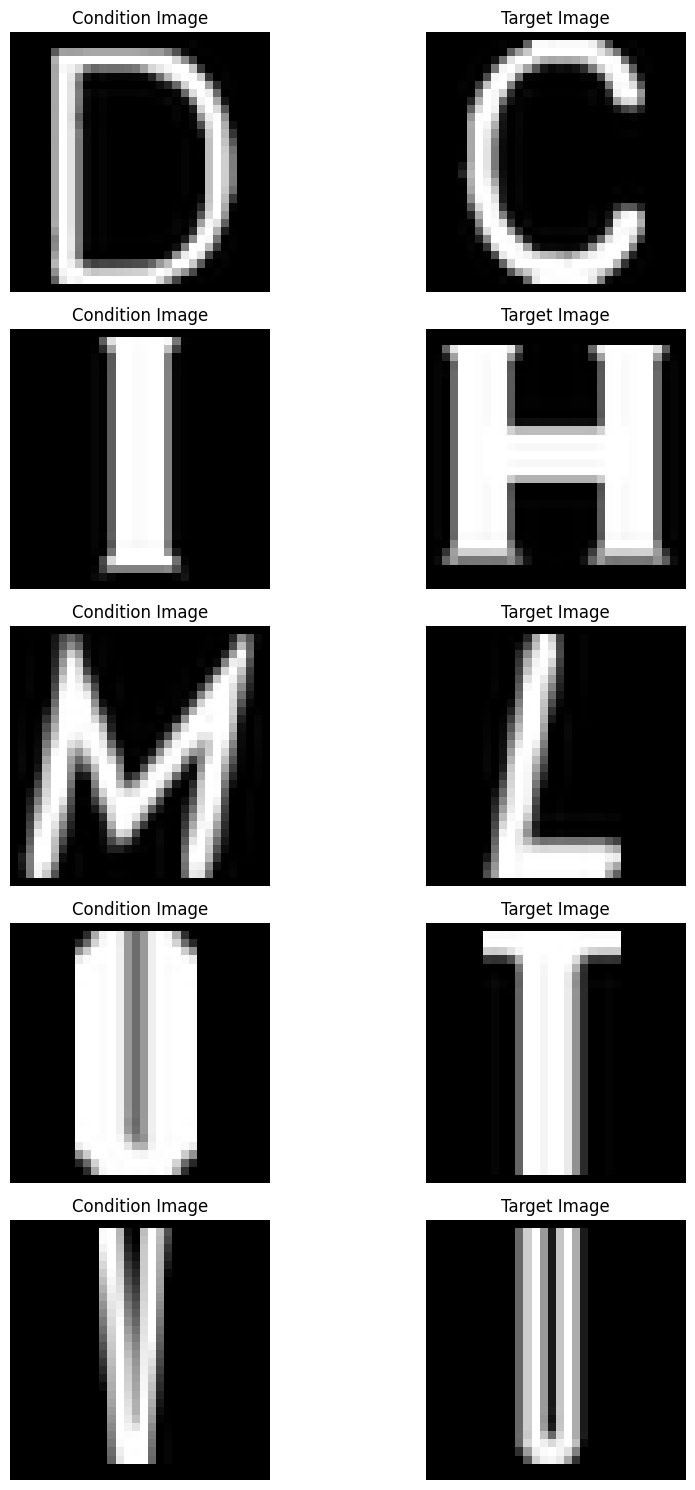

In [ ]:
# Display images from the dataloader
display_images_from_dataloader(
    dataloader=dataloader,  # Example: Dataloader for the first letter
    generator=None,  # Pass the generator model to visualize generated images
    # z_dim=z_dim,  # Latent dimension
    num_classes=num_classes,
    device=device,
    num_samples=5  # Number of samples to display
)


In [ ]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples, condition_imgs, labels):
    """
    Compute the gradient penalty for WGAN-GP.

    Args:
        discriminator (nn.Module): The discriminator model.
        real_samples (Tensor): Real samples from the dataset.
        fake_samples (Tensor): Generated samples from the generator.
        condition_imgs (Tensor): Conditional images.
        labels (Tensor): One-hot encoded labels for the target letters.

    Returns:
        Tensor: Gradient penalty value.
    """
    device = real_samples.device

    # Random weight for interpolation
    alpha = torch.rand(real_samples.size(0), 1, 1, 1, device=device)  # Shape: (batch_size, 1, 1, 1)
    alpha = alpha.expand_as(real_samples)

    # Interpolated samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    # Ensure condition_imgs and labels are not None
    assert condition_imgs is not None, "condition_imgs cannot be None for gradient penalty."
    assert labels is not None, "labels cannot be None for gradient penalty."

    # Compute discriminator output for interpolated samples
    d_interpolates = discriminator(interpolates, labels, condition_imgs)

    # Compute gradients
    grad_outputs = torch.ones(d_interpolates.size(), device=device)
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)  # Flatten gradients
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty



In [ ]:
def test_generator(generator, test_dataloader, z_dim, num_classes, device):
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        for i, (condition_imgs, target_labels, target_imgs) in enumerate(test_dataloader):
            # Move data to the appropriate device
            condition_imgs = condition_imgs.to(device)  # Add channel dimension
            target_labels = target_labels.to(device)
            batch_size = condition_imgs.size(0)

            # Generate latent noise
            z_s = torch.randn(batch_size, z_dim, device=device)

            # Display or evaluate generated images
            #for j in range(batch_size):
                # Extract data for the current sample
            condition_img = condition_imgs[0]
            z_s_single = z_s[0:0+1]  # Extract single latent vector
            target_label = torch.argmax(target_labels[0]).item()  # Extract scalar label

                # Display generated image using the updated function
            displayGeneratedImage(
                    class_index=target_label,
                    generator=generator,
                    z_s=z_s_single,
                    num_classes=num_classes,
                    condition_img=condition_img,
                    device=device
                )

    generator.train()  # Return generator to training mode


In [ ]:
epochs = 500

Epoch [1/500], D_loss: -0.5685124397277832, G_loss: -0.13420481979846954
Epoch [2/500], D_loss: 1.8015269041061401, G_loss: -0.4640359878540039
Epoch [3/500], D_loss: -0.32190799713134766, G_loss: -0.13374000787734985
Epoch [4/500], D_loss: -0.5465976595878601, G_loss: -0.17361894249916077
Epoch [5/500], D_loss: -0.5202294588088989, G_loss: -0.2150934338569641
Epoch [6/500], D_loss: -0.674292266368866, G_loss: -0.18254238367080688
Epoch [7/500], D_loss: -0.7585704326629639, G_loss: -0.11702285706996918
Epoch [8/500], D_loss: -0.29117217659950256, G_loss: -0.24623018503189087
Epoch [9/500], D_loss: -0.7320423722267151, G_loss: -0.12146878242492676
Epoch [10/500], D_loss: -0.7760435342788696, G_loss: -0.07275386154651642
Epoch [11/500], D_loss: -0.3377455472946167, G_loss: -0.3252699375152588
Epoch [12/500], D_loss: -0.6862594485282898, G_loss: -0.10145318508148193
Epoch [13/500], D_loss: -0.7233483195304871, G_loss: -0.1765981763601303
Epoch [14/500], D_loss: -0.7553718090057373, G_loss

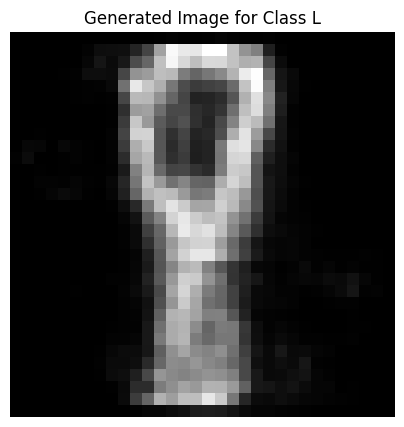

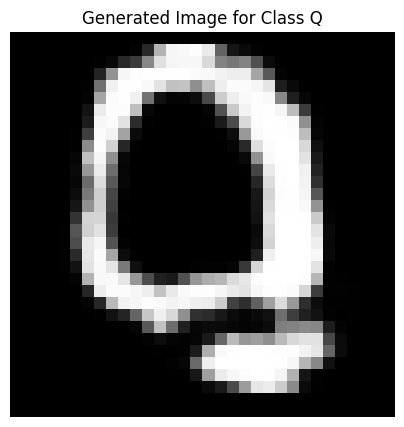

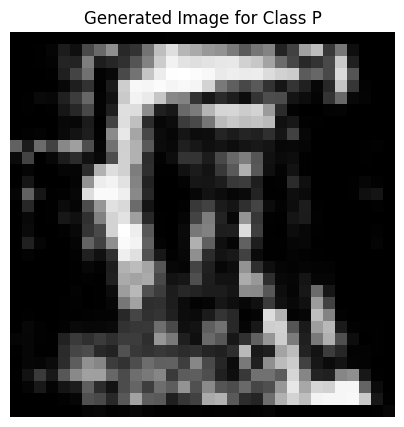

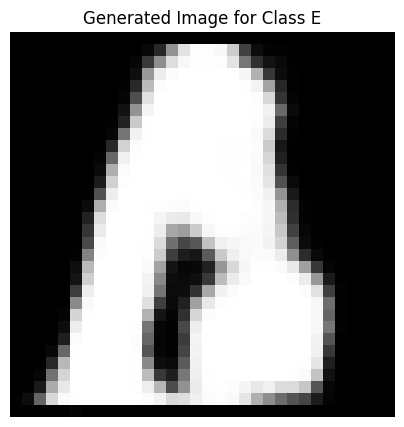

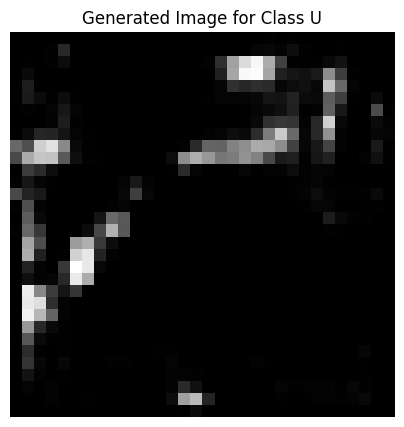

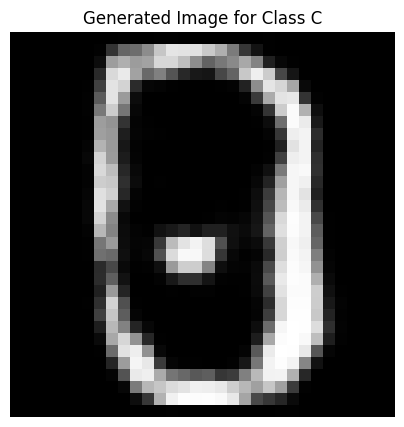

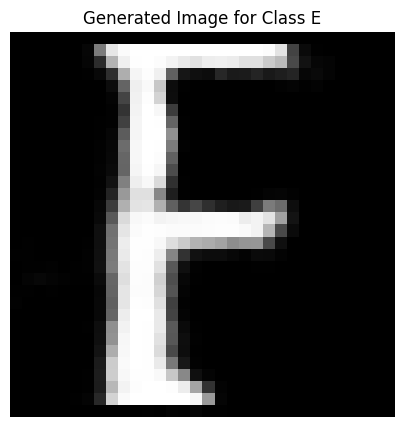

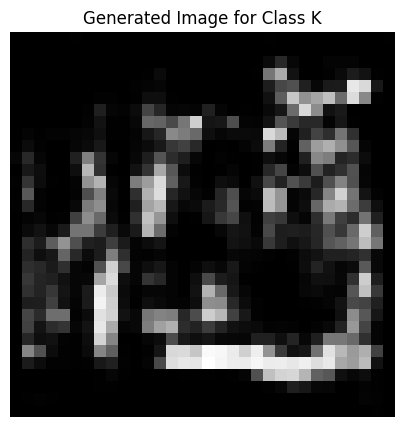

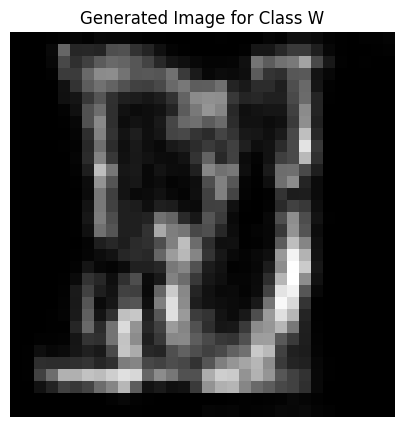

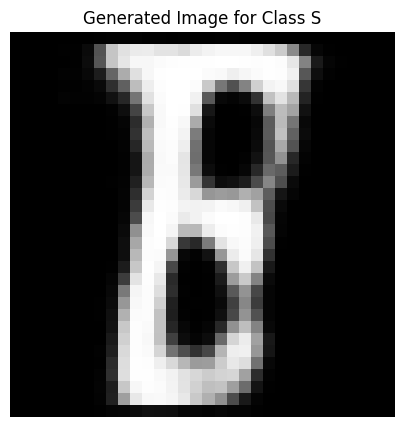

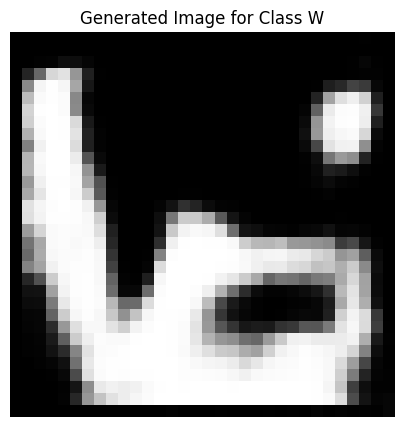

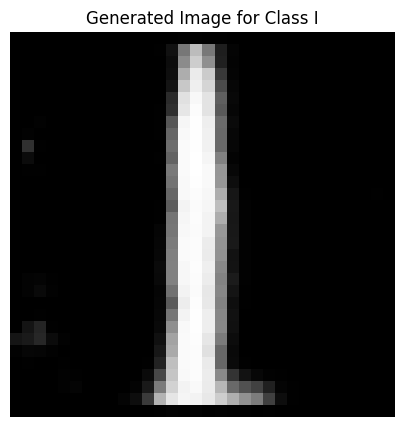

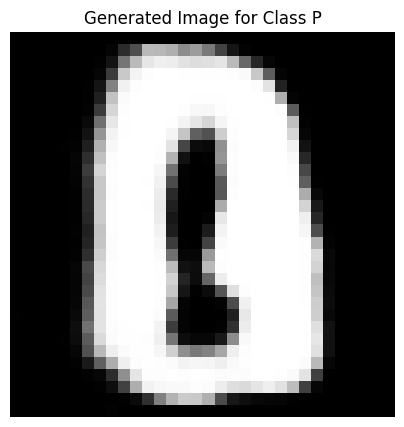

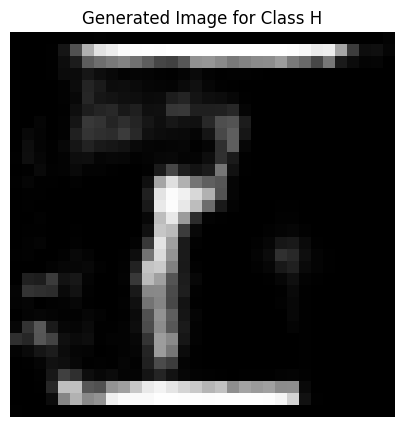

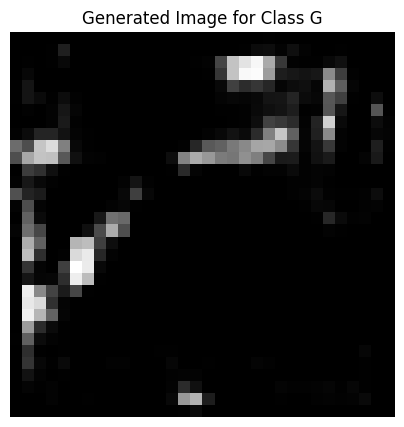

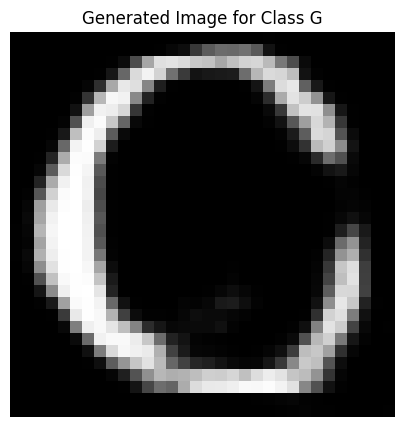

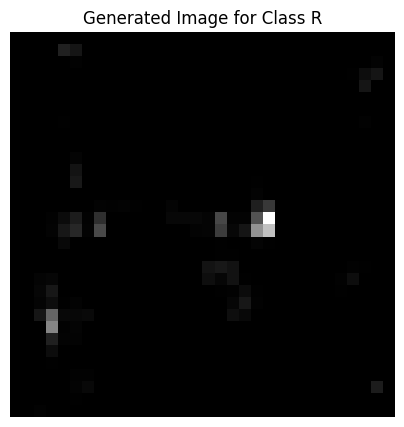

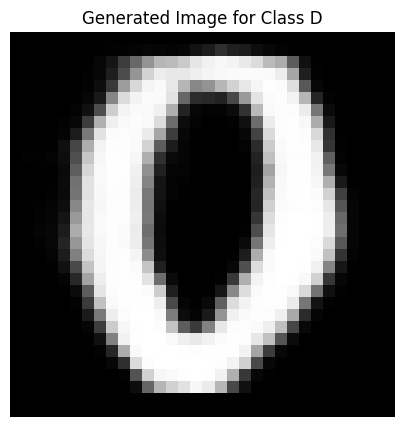

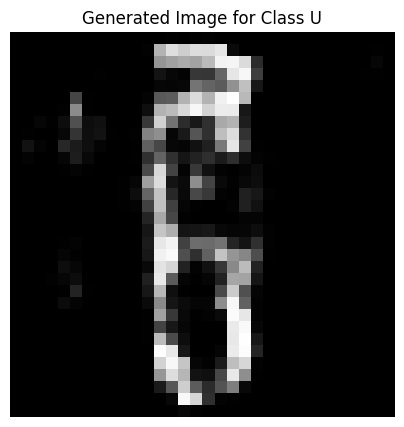

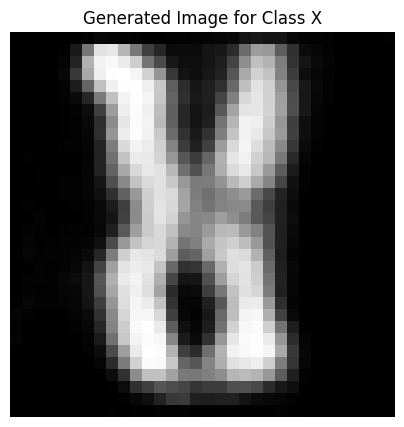

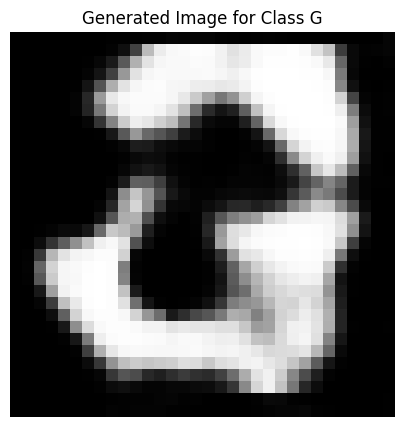

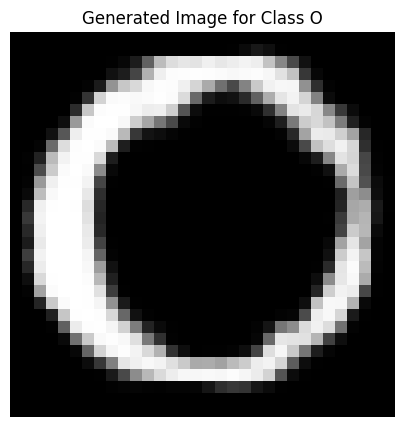

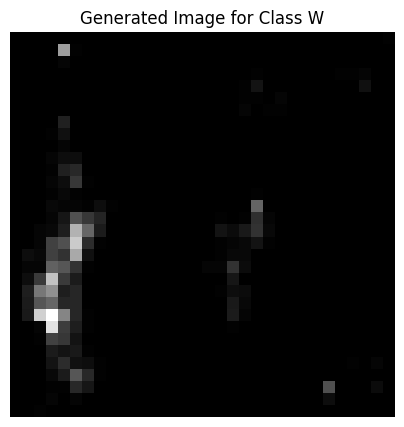

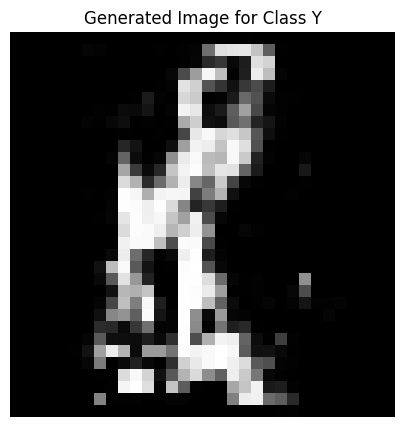

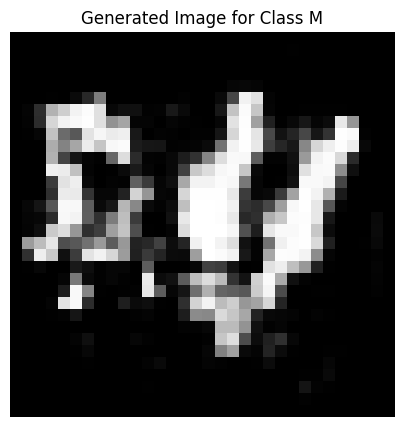

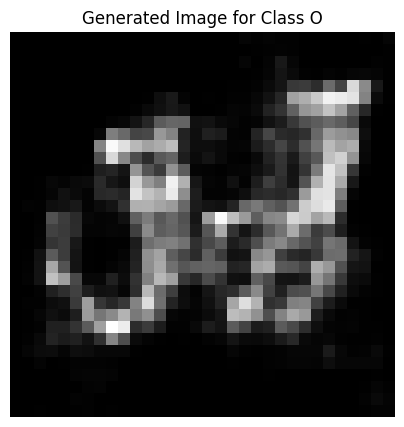

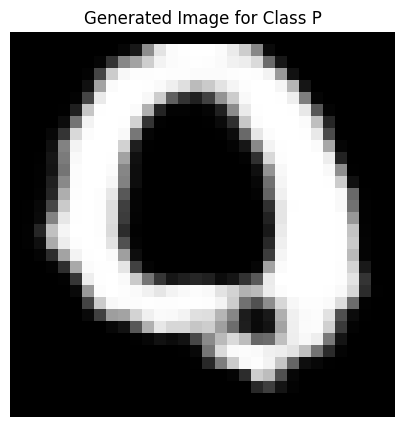

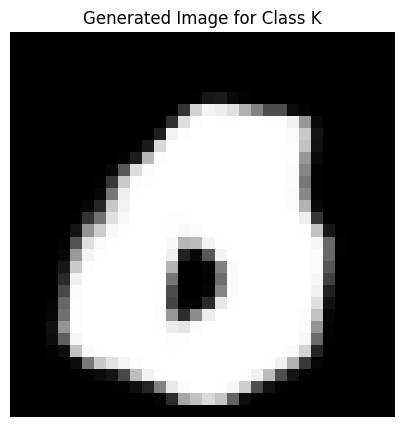

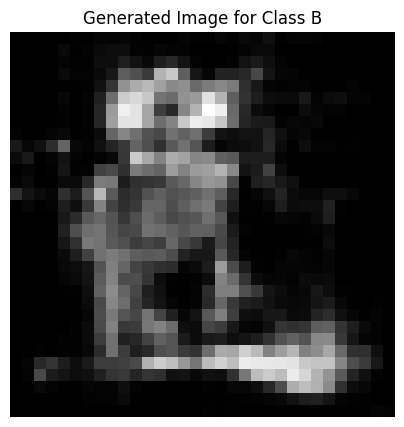

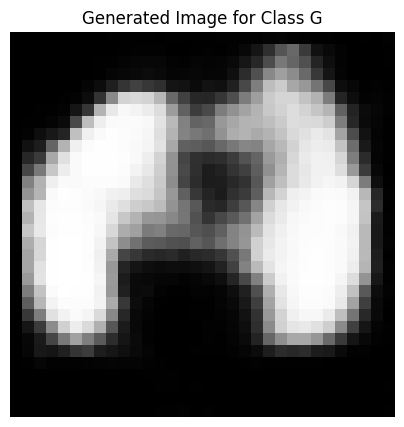

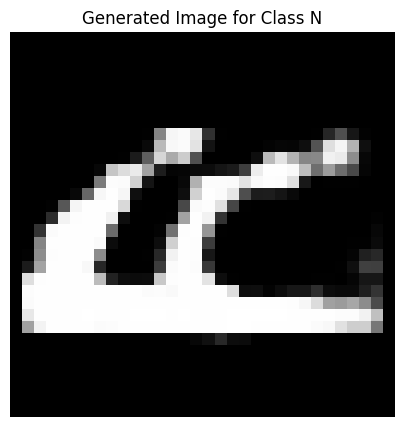

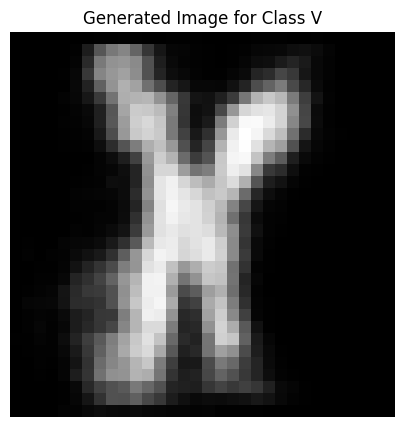

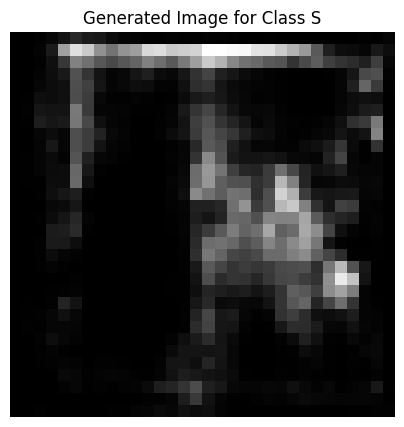

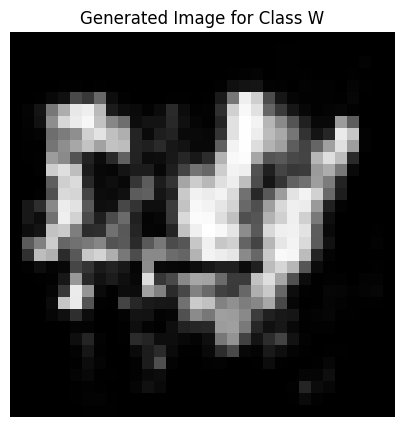

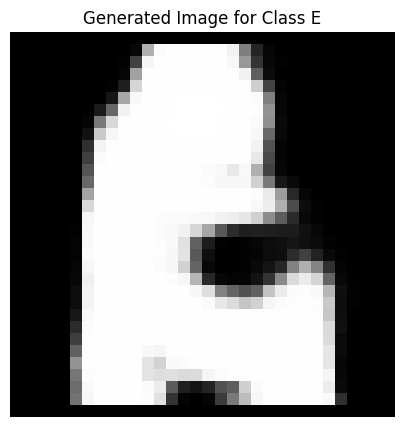

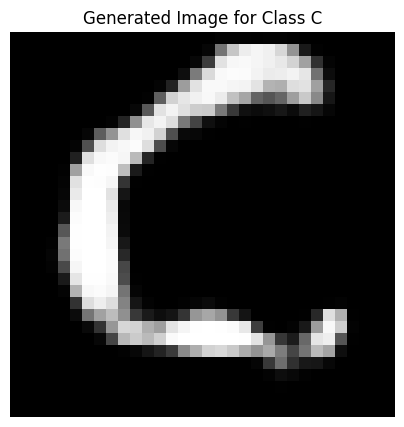

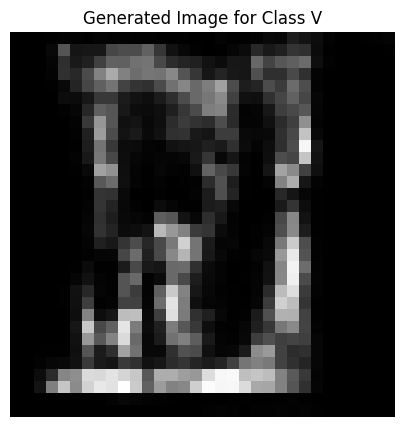

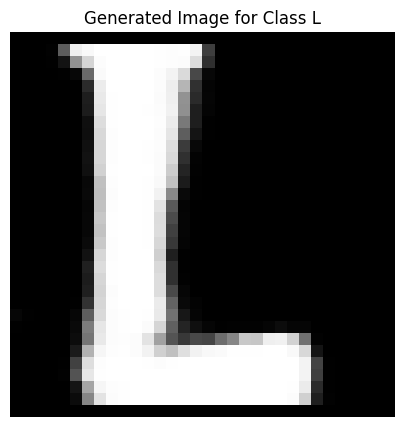

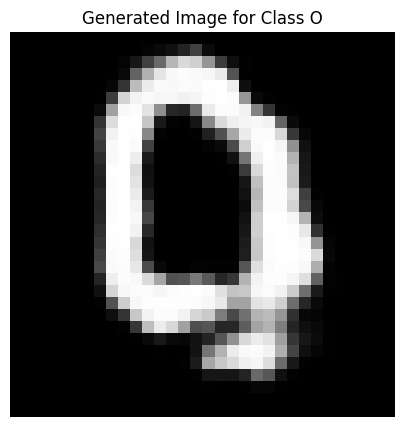

Epoch [101/500], D_loss: -0.17410908639431, G_loss: -0.5067355632781982
Epoch [102/500], D_loss: -0.16191992163658142, G_loss: -0.3288038969039917
Epoch [103/500], D_loss: -0.21145187318325043, G_loss: -0.3723461329936981
Epoch [104/500], D_loss: -0.15570873022079468, G_loss: -0.37997859716415405
Epoch [105/500], D_loss: -0.19336844980716705, G_loss: -0.42709124088287354
Epoch [106/500], D_loss: -0.19254109263420105, G_loss: -0.42244115471839905
Epoch [107/500], D_loss: -0.1772436946630478, G_loss: -0.40137743949890137
Epoch [108/500], D_loss: -0.1700911819934845, G_loss: -0.4572570025920868
Epoch [109/500], D_loss: -0.195383220911026, G_loss: -0.4617769122123718
Epoch [110/500], D_loss: -0.1796766221523285, G_loss: -0.380064457654953
Epoch [111/500], D_loss: -0.19325977563858032, G_loss: -0.3610798120498657
Epoch [112/500], D_loss: -0.15543745458126068, G_loss: -0.3356187641620636
Epoch [113/500], D_loss: -0.11513950675725937, G_loss: -0.5844728946685791
Epoch [114/500], D_loss: -0.12

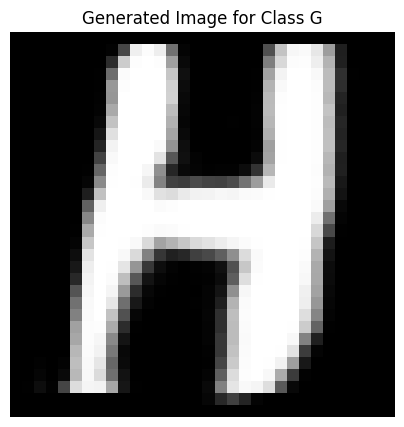

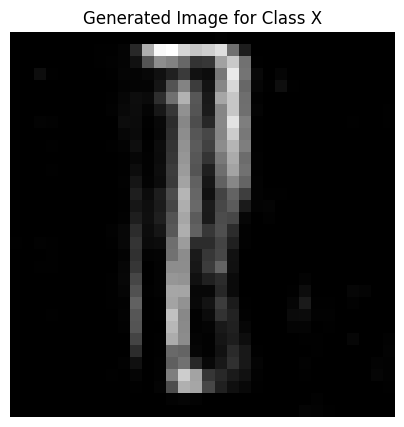

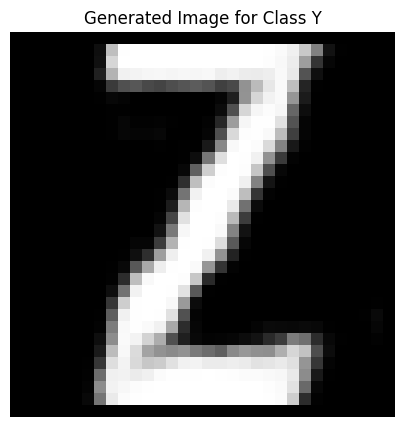

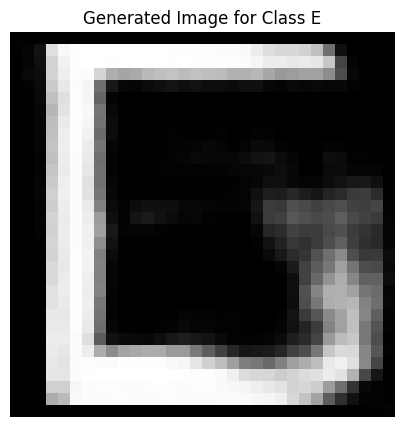

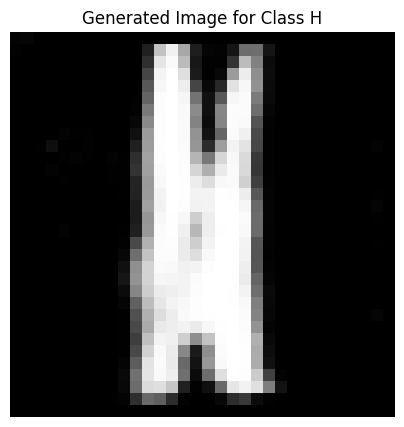

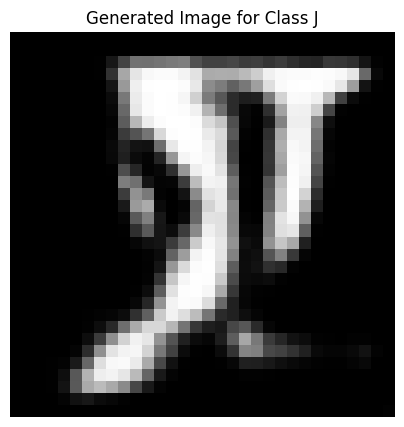

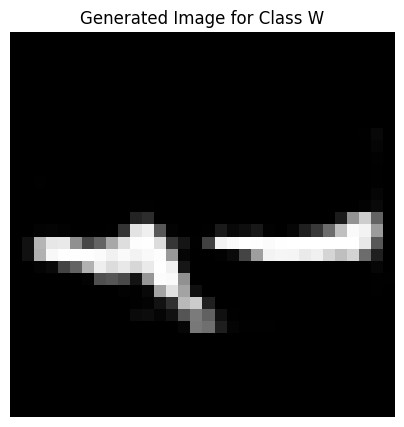

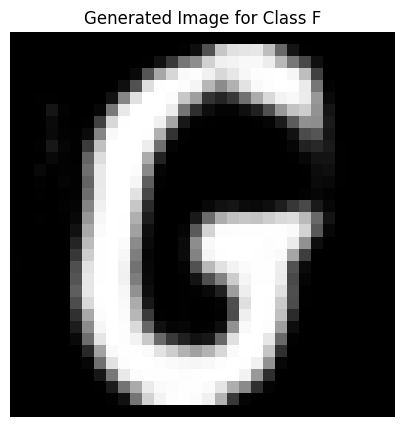

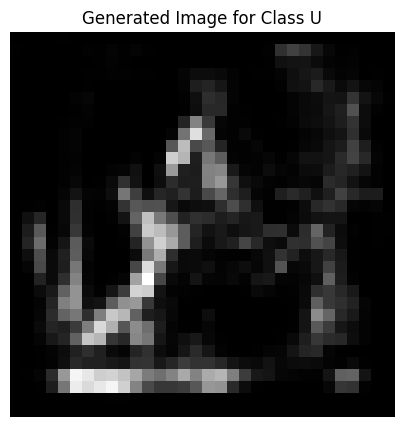

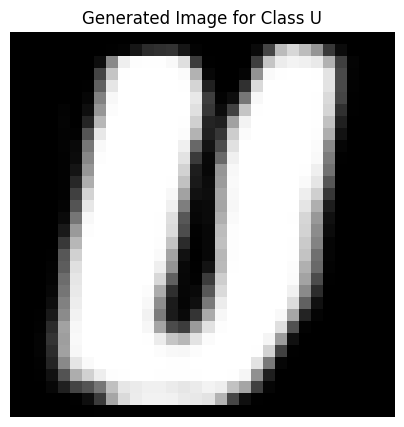

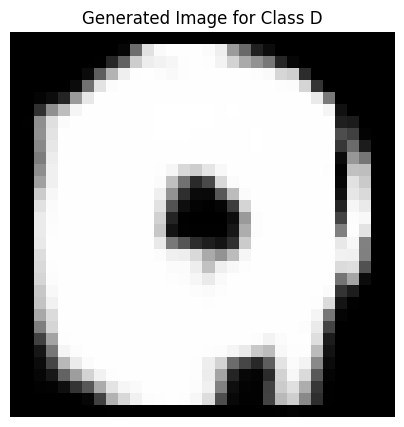

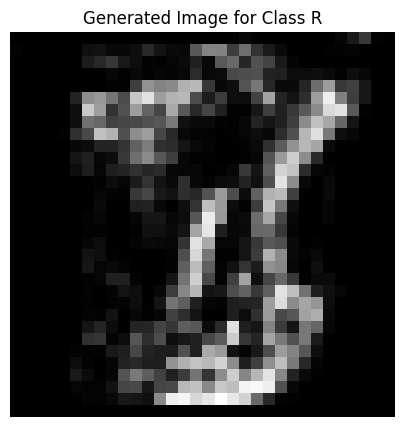

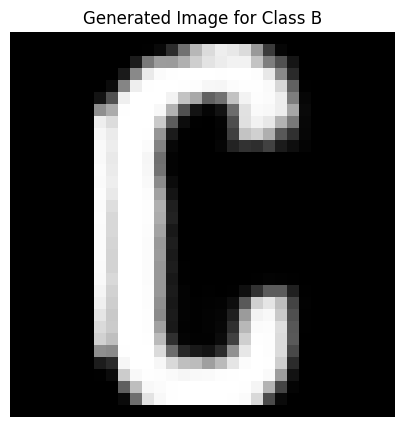

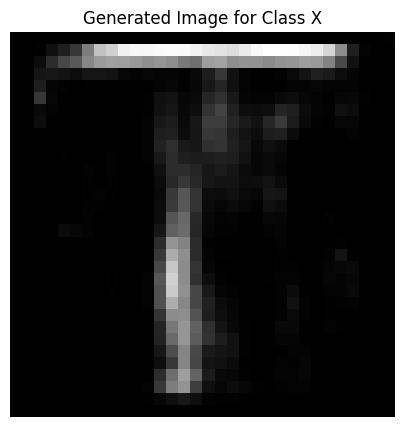

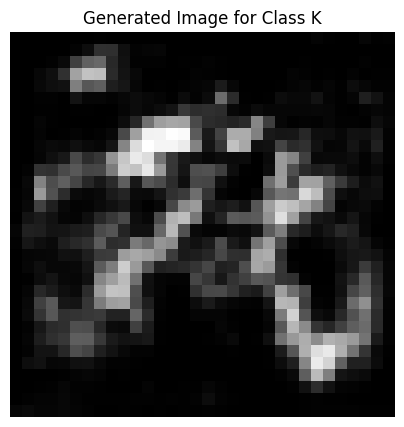

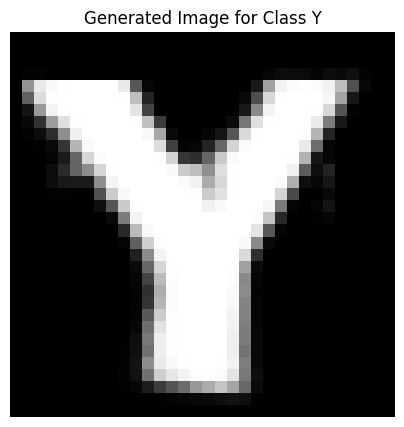

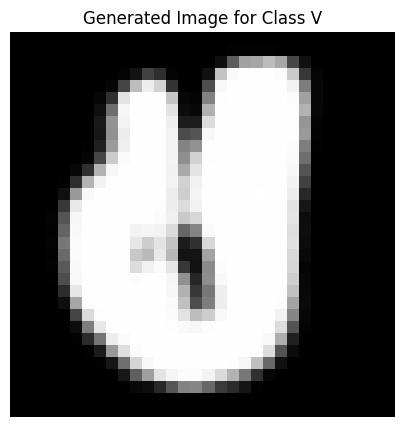

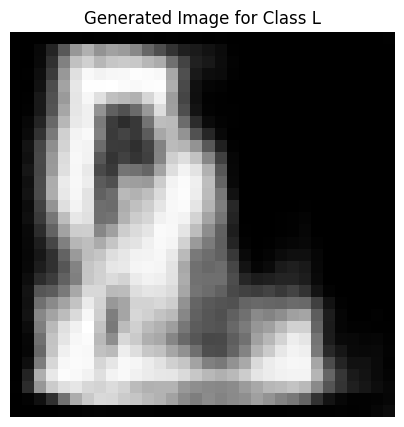

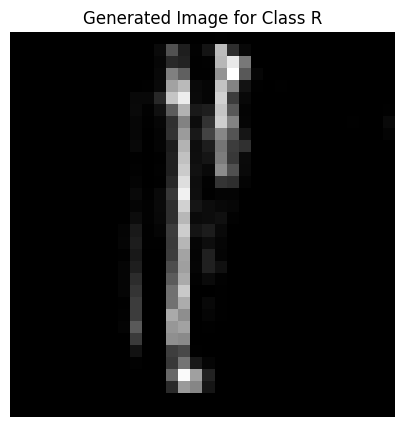

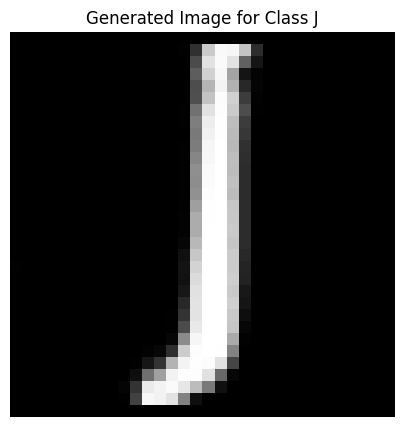

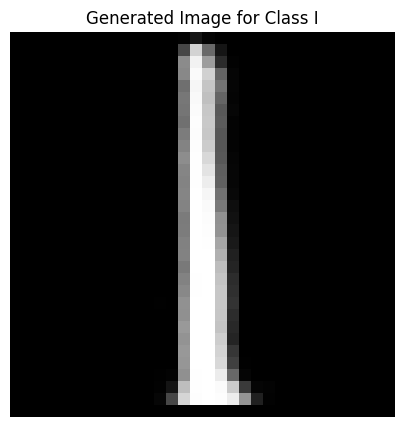

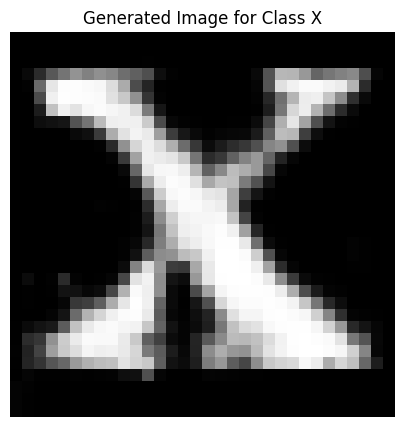

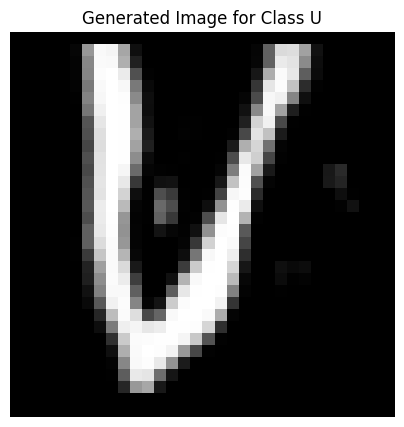

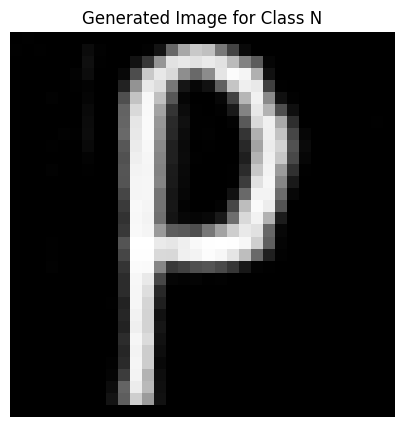

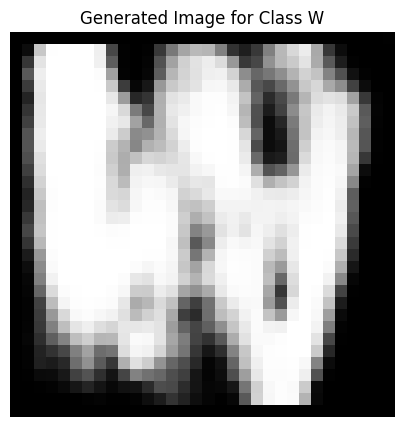

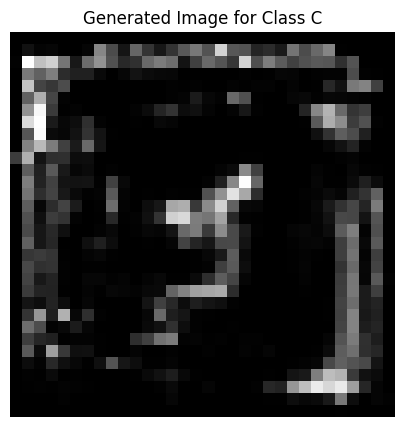

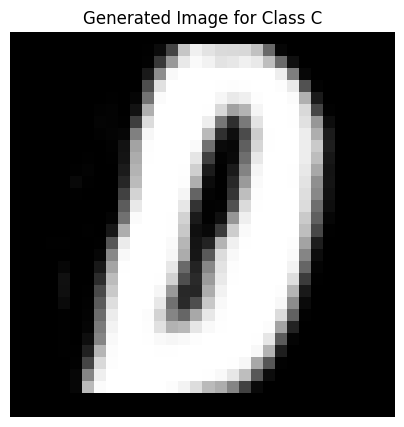

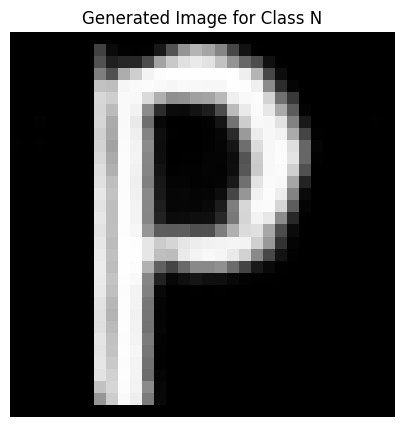

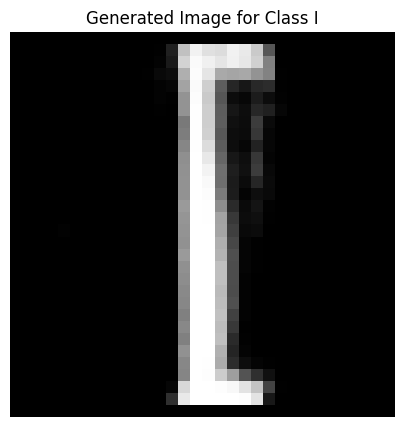

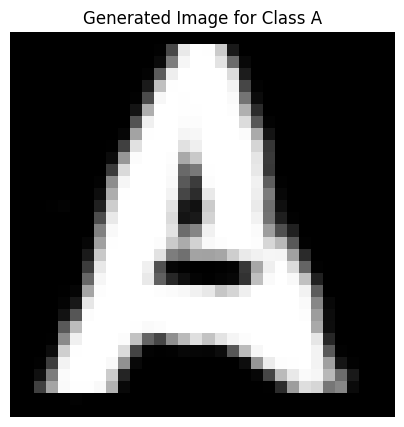

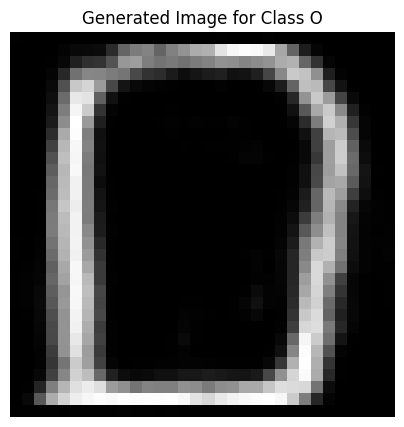

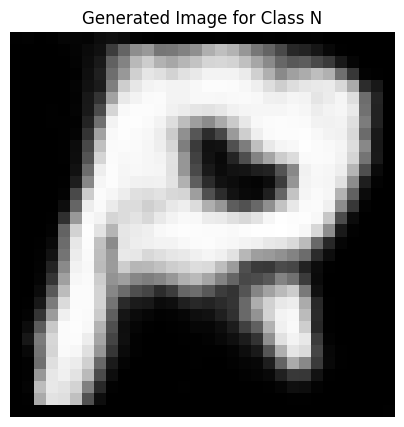

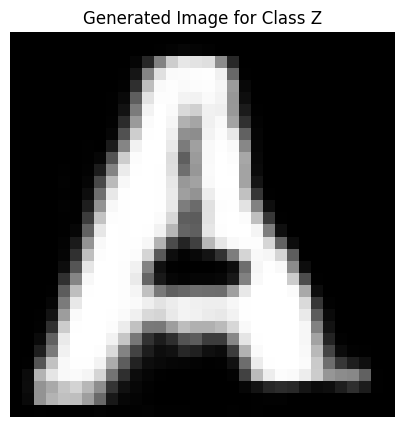

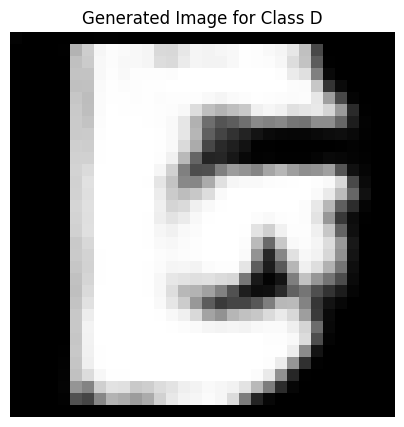

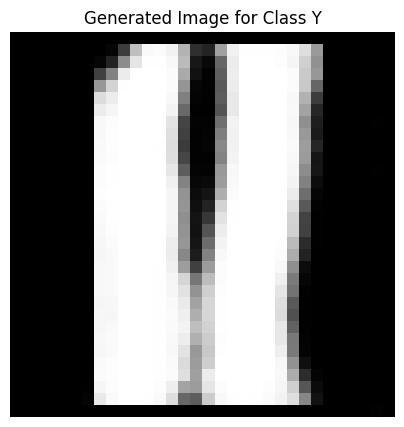

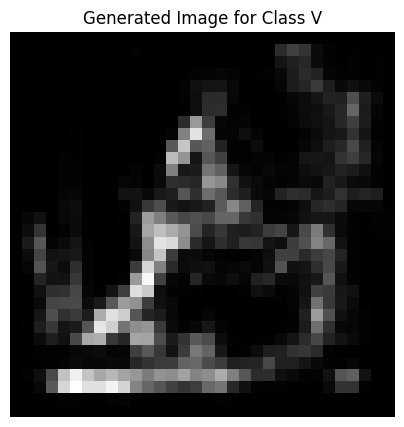

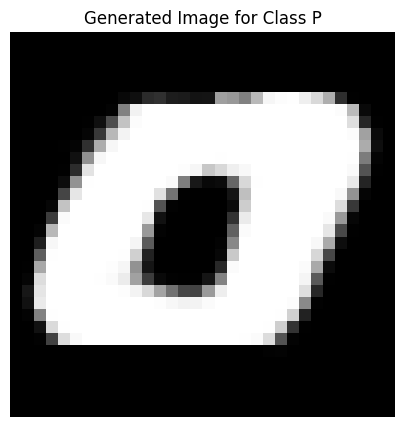

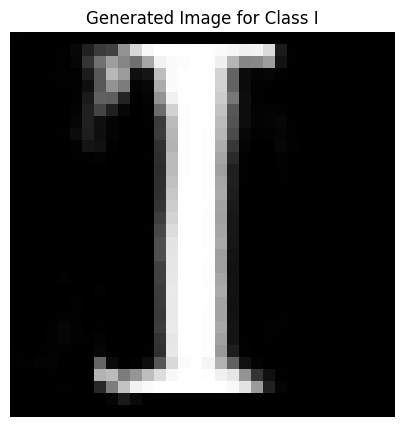

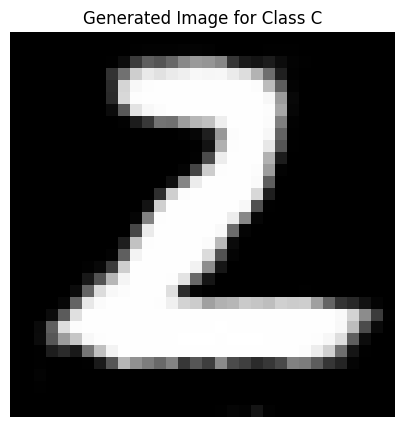

Epoch [201/500], D_loss: -0.17706052958965302, G_loss: -0.3638448715209961
Epoch [202/500], D_loss: -0.19359090924263, G_loss: -0.37667545676231384
Epoch [203/500], D_loss: -0.2063300460577011, G_loss: -0.3974950313568115
Epoch [204/500], D_loss: -0.16798841953277588, G_loss: -0.470792680978775
Epoch [205/500], D_loss: -0.227027028799057, G_loss: -0.3241732120513916
Epoch [206/500], D_loss: -0.20822644233703613, G_loss: -0.43937891721725464
Epoch [207/500], D_loss: -0.21090218424797058, G_loss: -0.4078931212425232
Epoch [208/500], D_loss: -0.19109655916690826, G_loss: -0.44845908880233765
Epoch [209/500], D_loss: -0.23147140443325043, G_loss: -0.3382250666618347
Epoch [210/500], D_loss: -0.15412726998329163, G_loss: -0.5967371463775635
Epoch [211/500], D_loss: -0.23516574501991272, G_loss: -0.39303654432296753
Epoch [212/500], D_loss: -0.16438210010528564, G_loss: -0.4699960947036743
Epoch [213/500], D_loss: -0.2344224601984024, G_loss: -0.48803168535232544
Epoch [214/500], D_loss: -0.

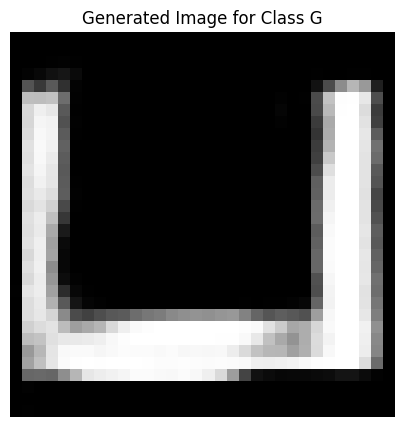

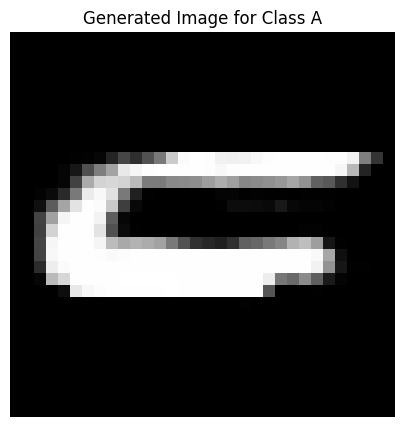

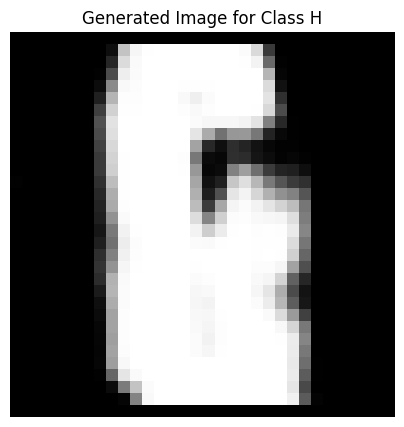

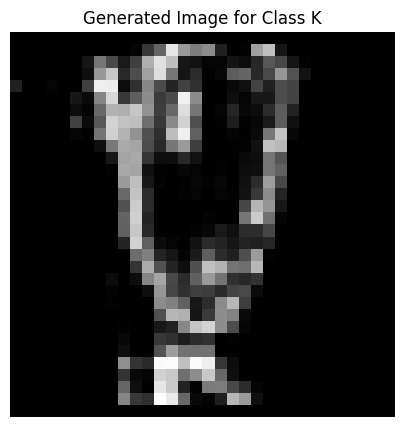

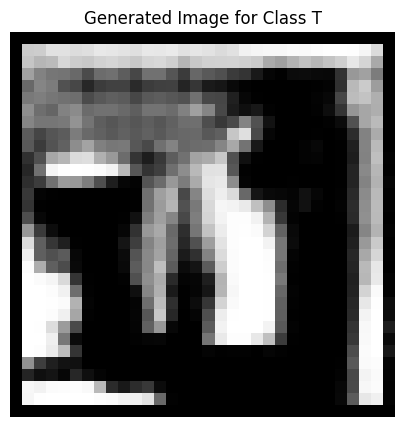

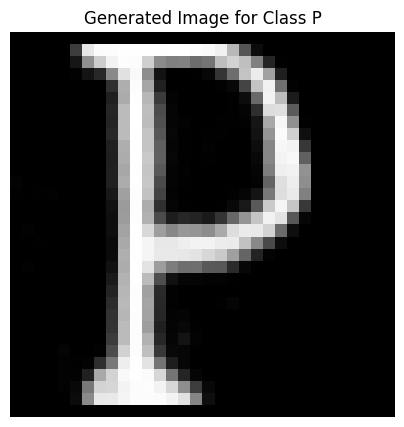

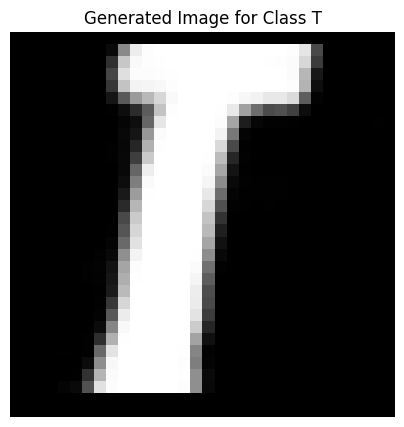

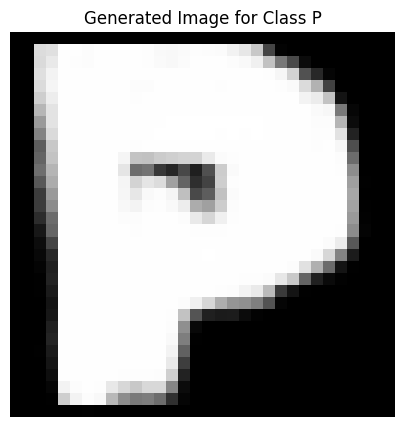

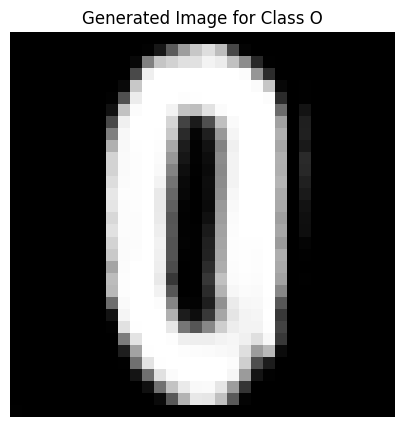

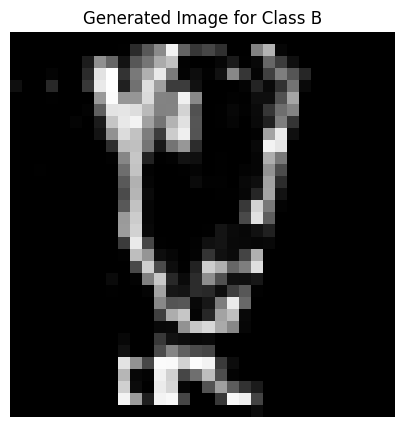

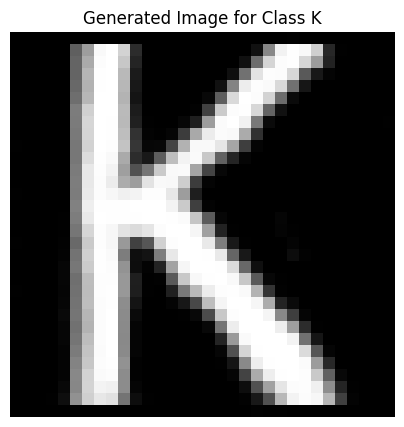

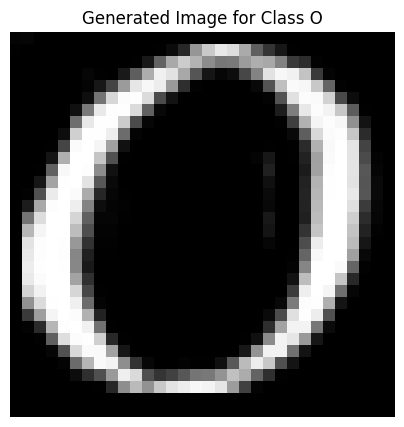

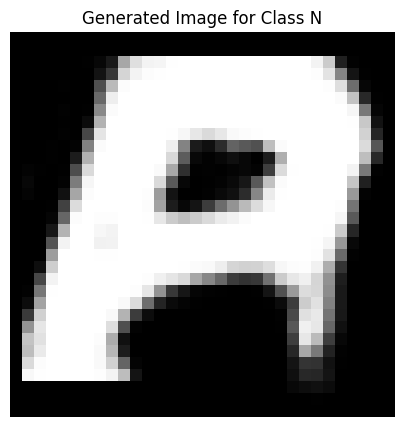

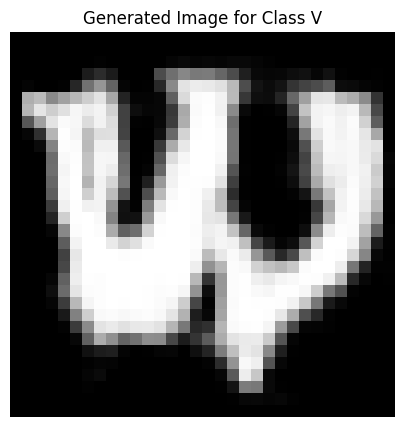

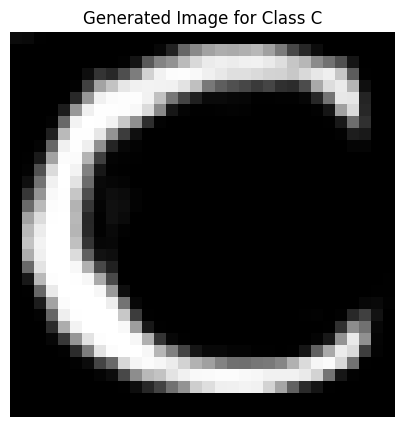

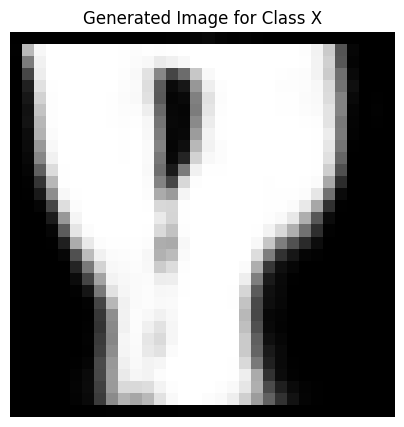

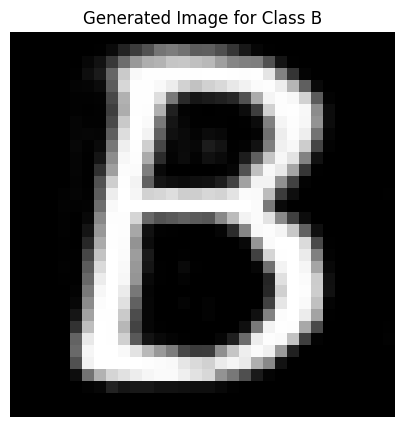

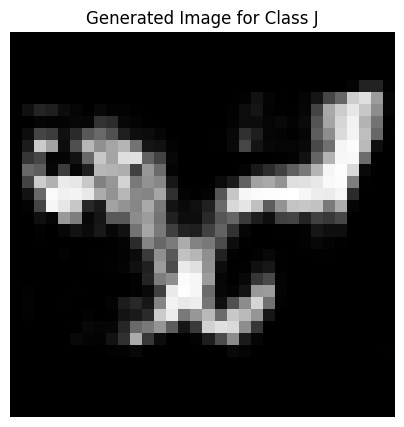

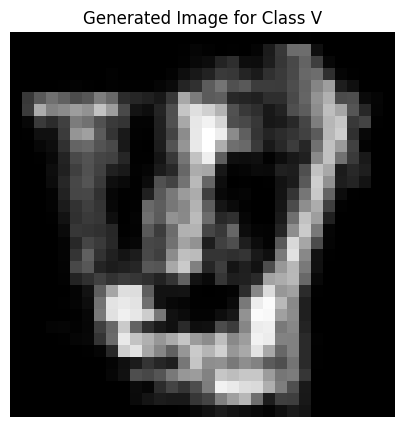

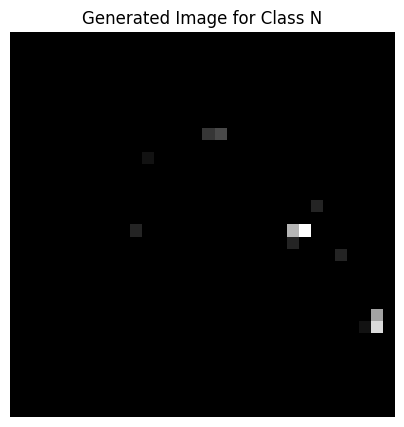

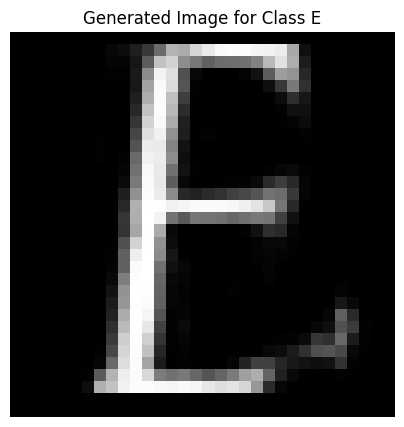

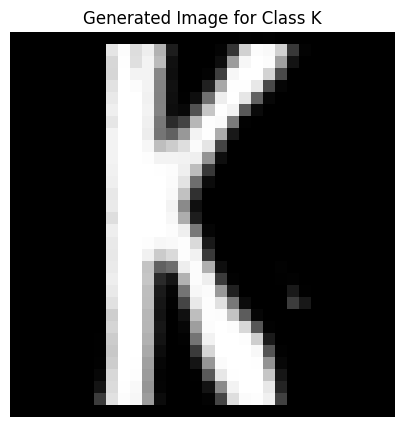

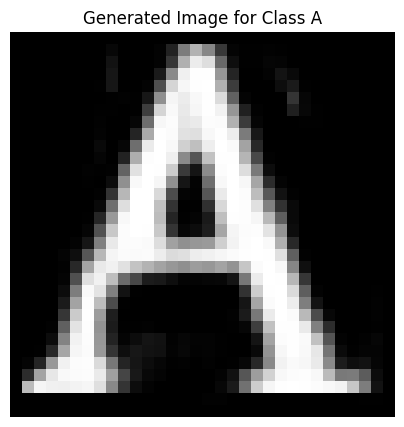

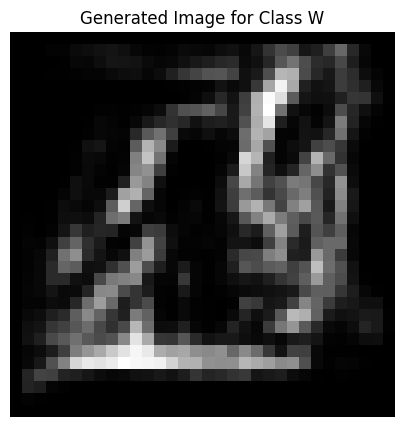

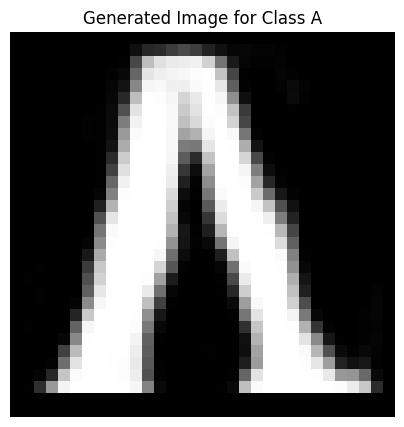

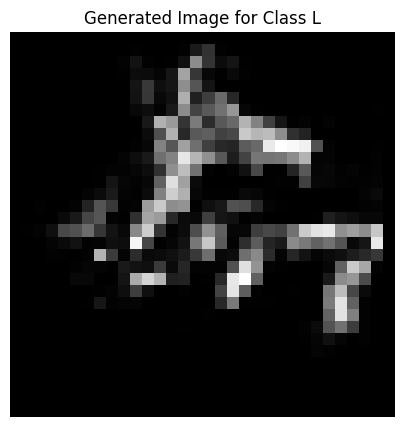

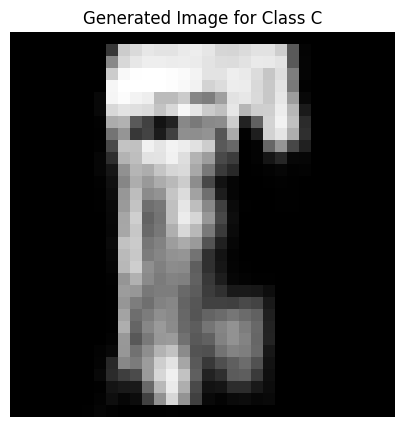

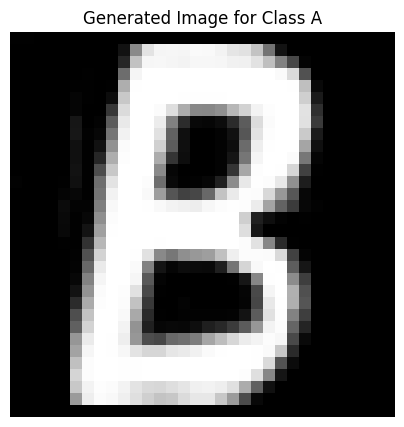

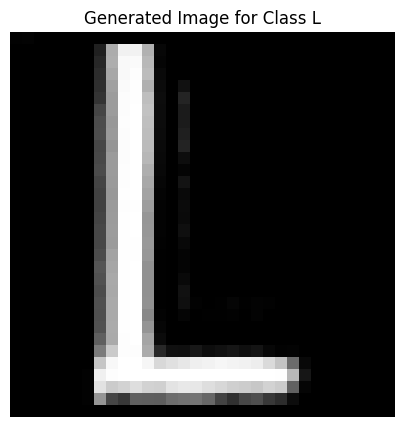

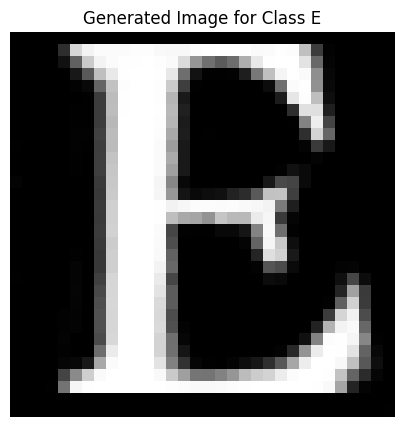

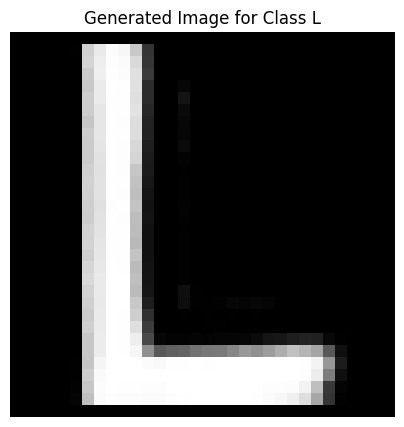

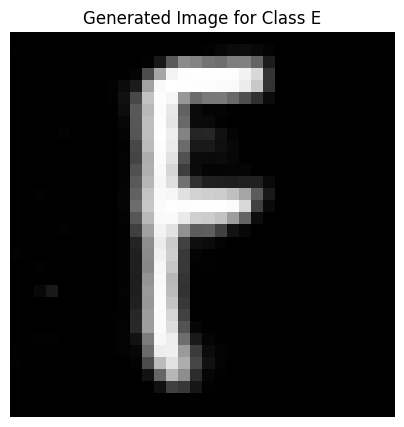

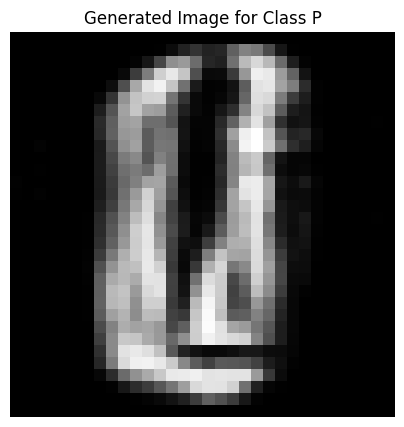

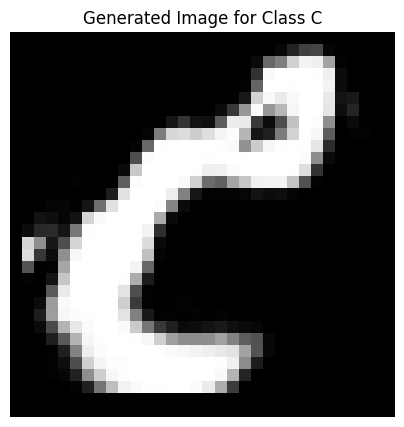

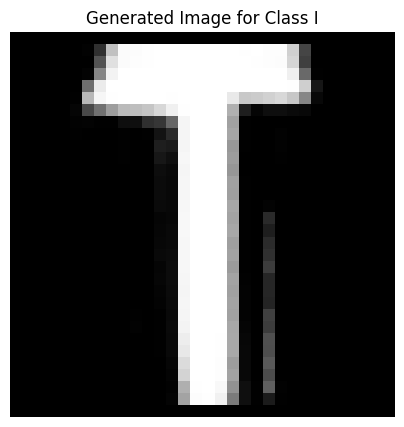

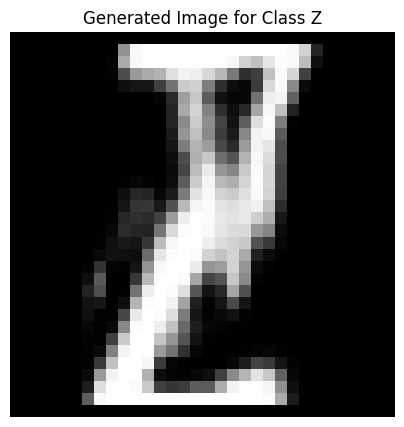

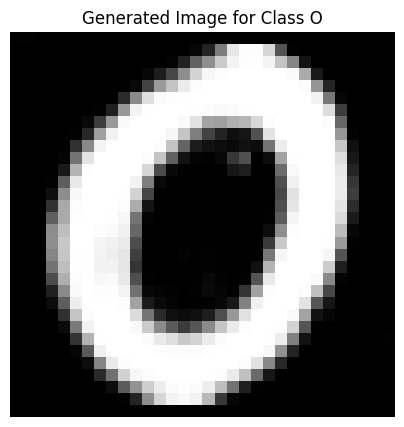

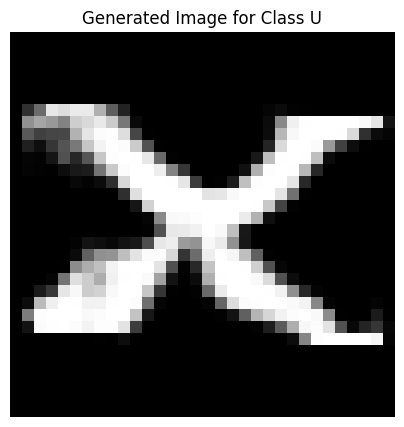

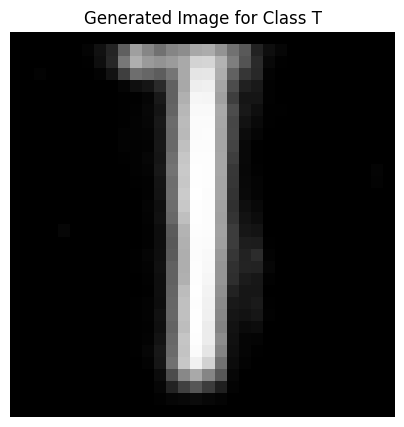

Epoch [301/500], D_loss: -0.22713616490364075, G_loss: -0.43528228998184204
Epoch [302/500], D_loss: -0.20739495754241943, G_loss: -0.5080764293670654
Epoch [303/500], D_loss: -0.23239901661872864, G_loss: -0.4201209545135498
Epoch [304/500], D_loss: -0.20956340432167053, G_loss: -0.40458160638809204
Epoch [305/500], D_loss: -0.20345190167427063, G_loss: -0.41906243562698364
Epoch [306/500], D_loss: -0.21028947830200195, G_loss: -0.4047246277332306
Epoch [307/500], D_loss: -0.17976704239845276, G_loss: -0.4210927188396454
Epoch [308/500], D_loss: -0.2153433859348297, G_loss: -0.48436617851257324
Epoch [309/500], D_loss: -0.20753467082977295, G_loss: -0.3758142590522766
Epoch [310/500], D_loss: -0.23280848562717438, G_loss: -0.4111859202384949
Epoch [311/500], D_loss: -0.2292483150959015, G_loss: -0.492969810962677
Epoch [312/500], D_loss: -0.23116031289100647, G_loss: -0.42729949951171875
Epoch [313/500], D_loss: -0.20381203293800354, G_loss: -0.40940791368484497
Epoch [314/500], D_los

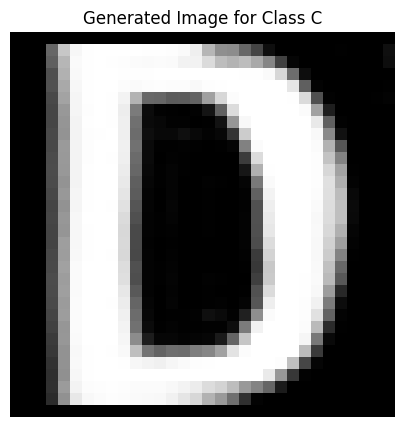

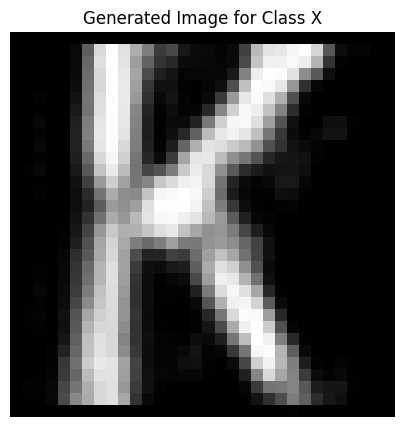

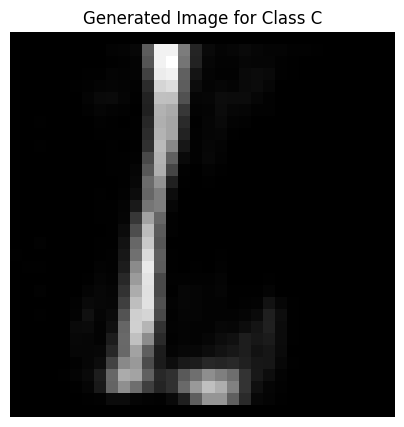

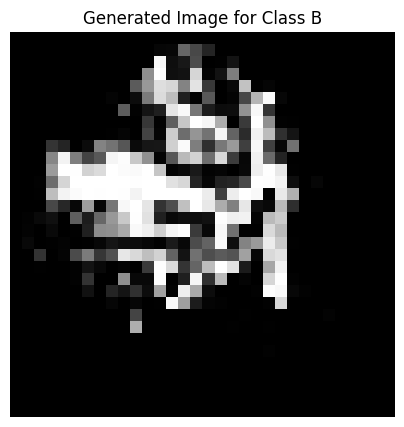

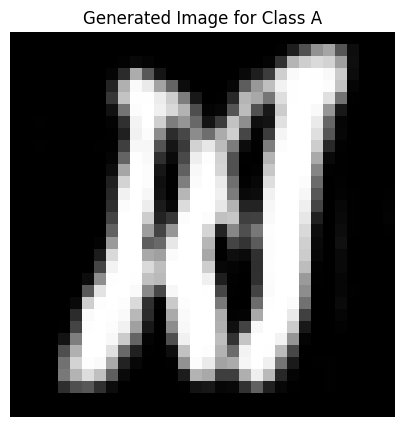

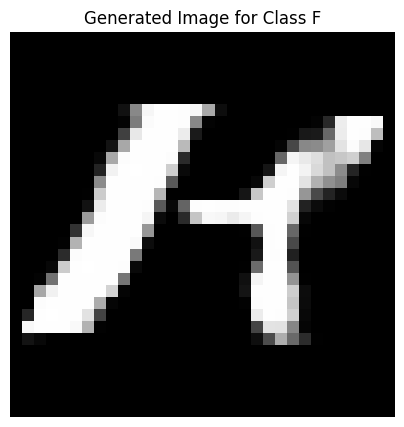

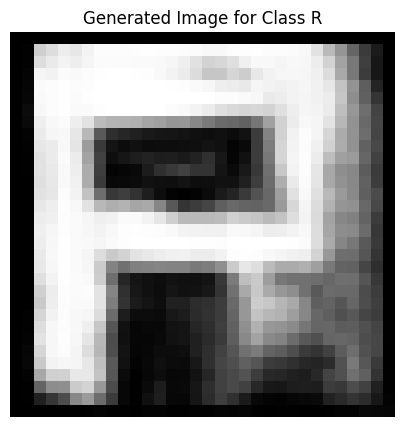

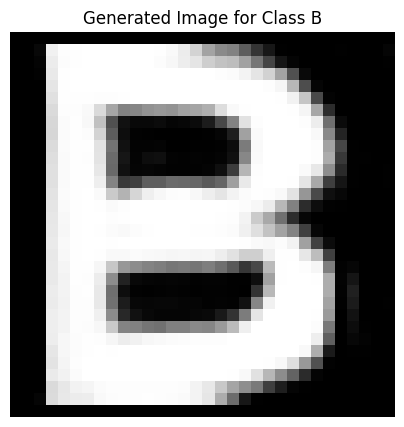

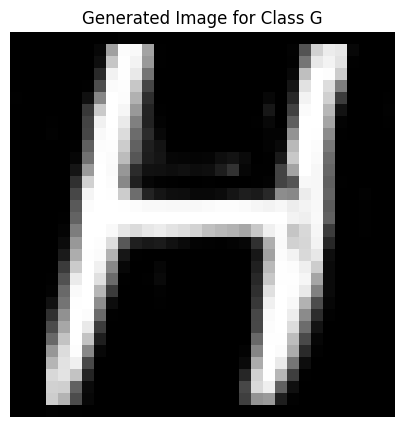

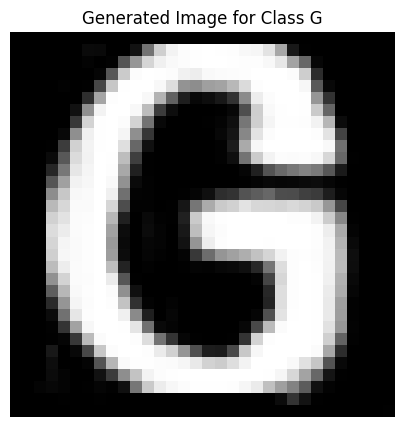

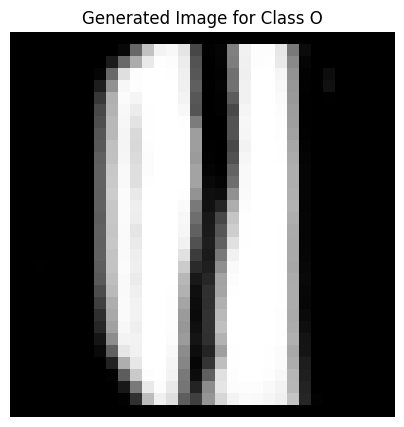

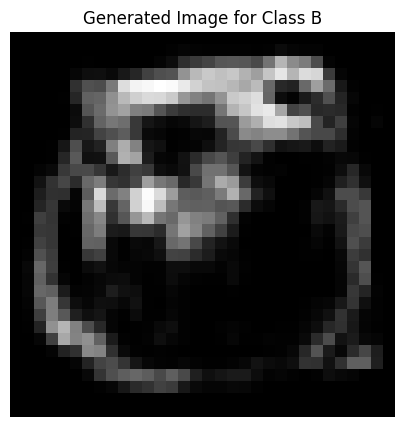

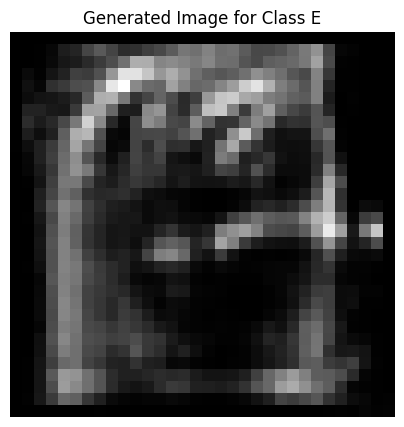

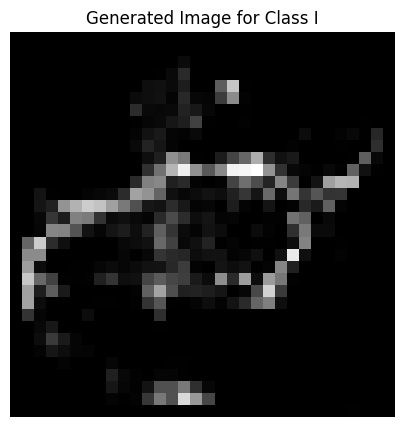

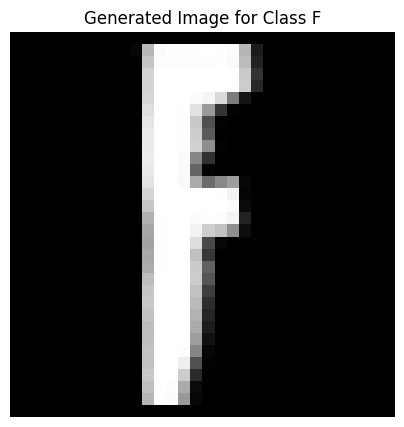

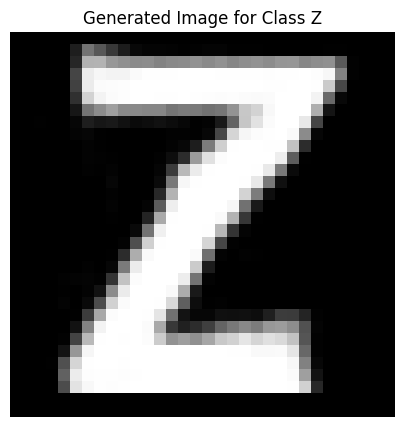

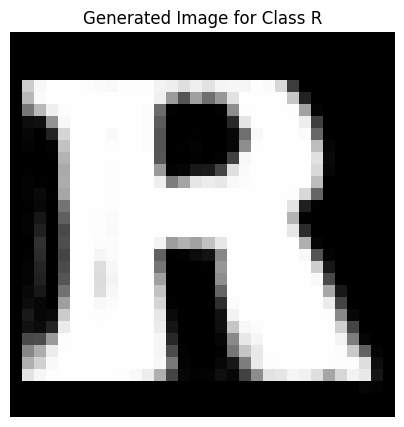

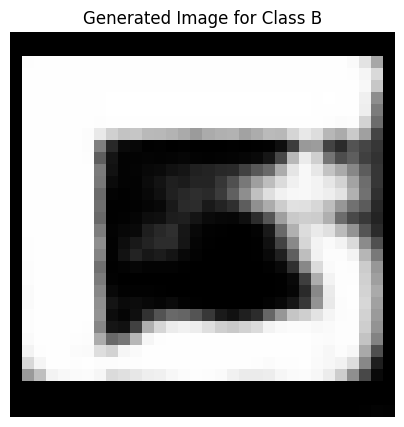

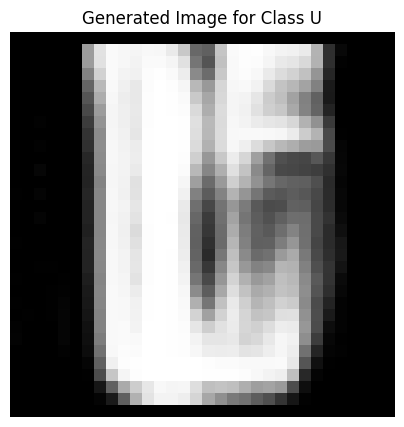

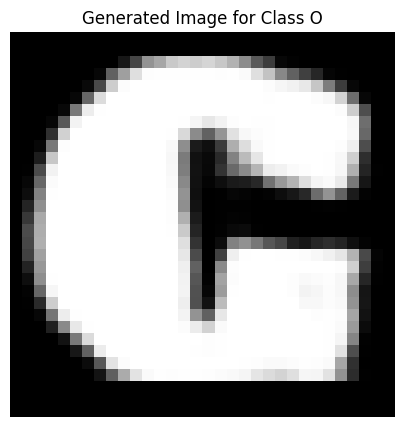

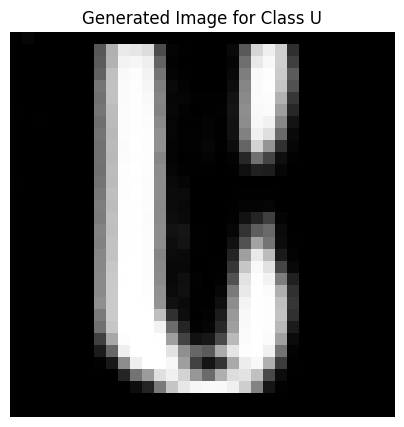

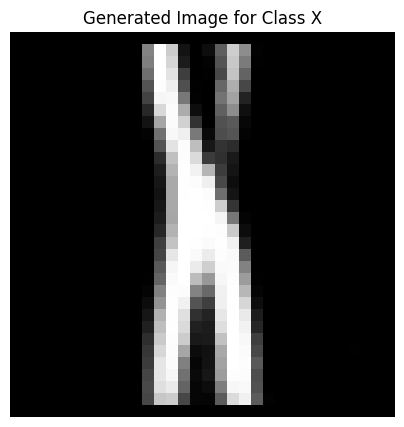

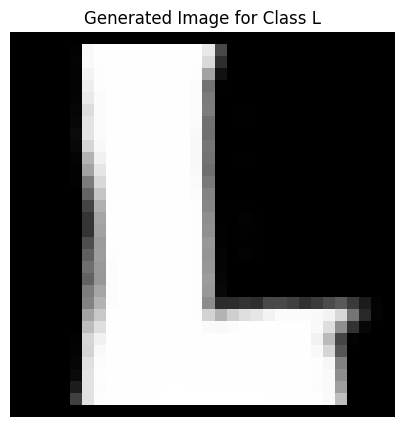

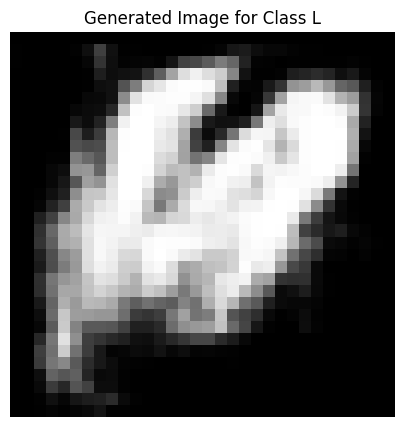

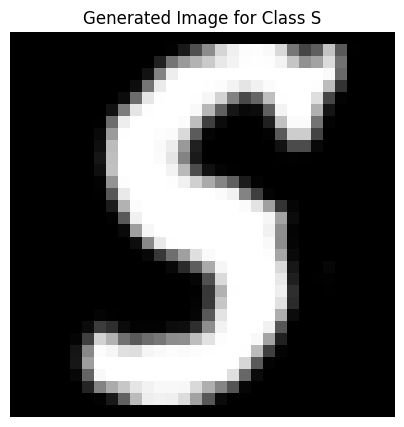

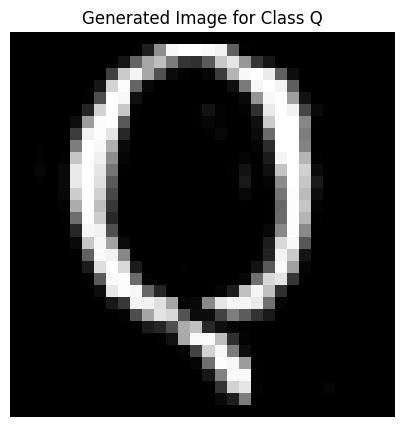

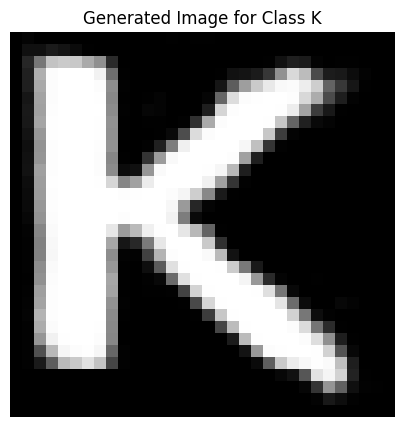

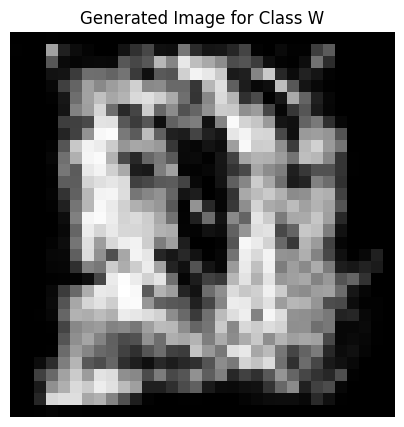

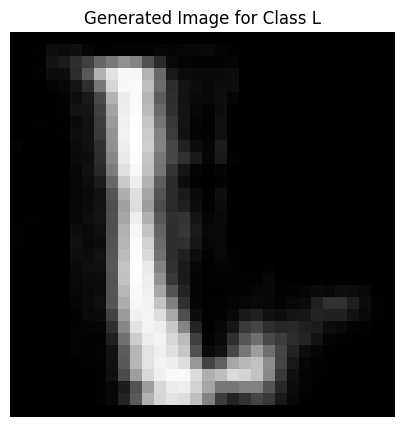

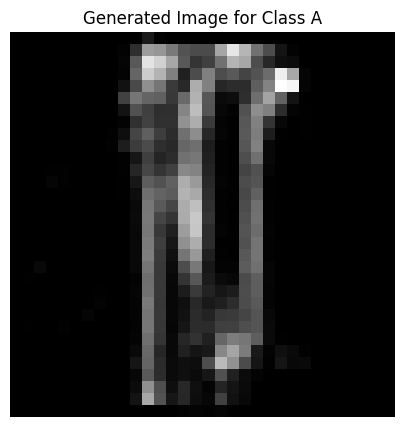

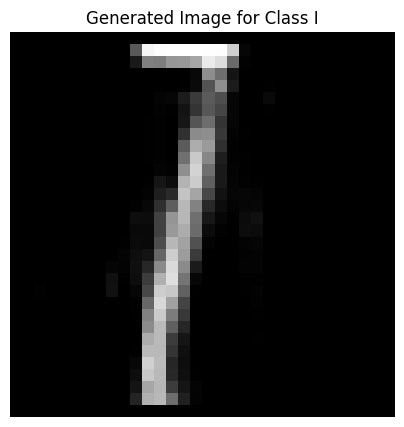

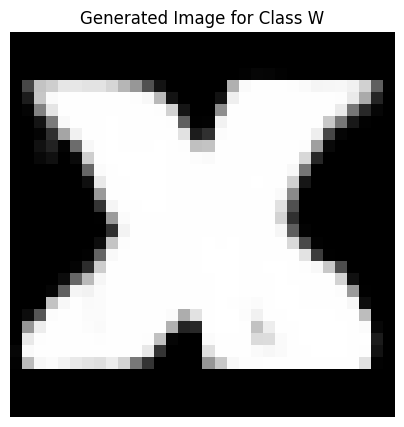

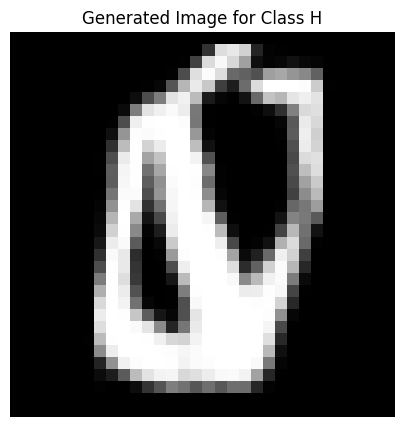

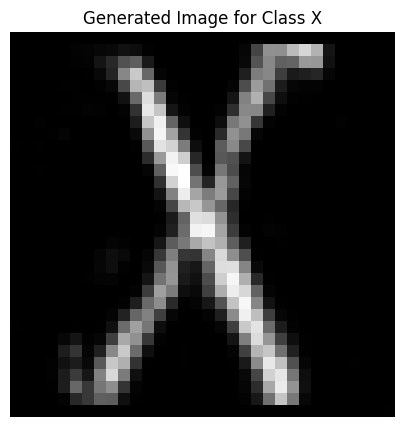

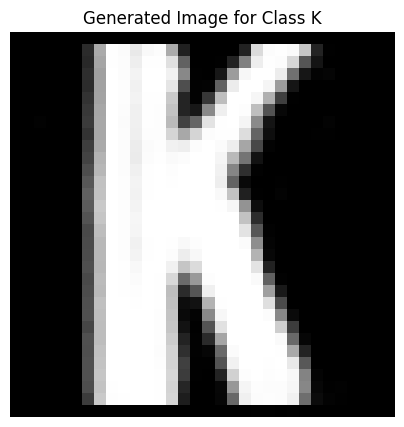

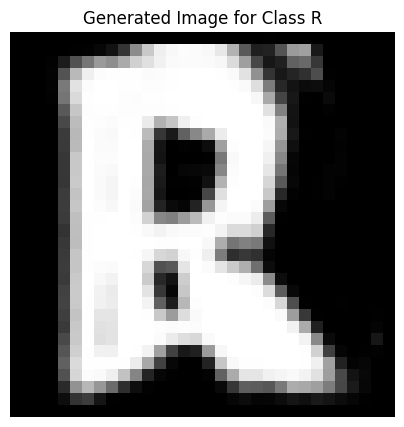

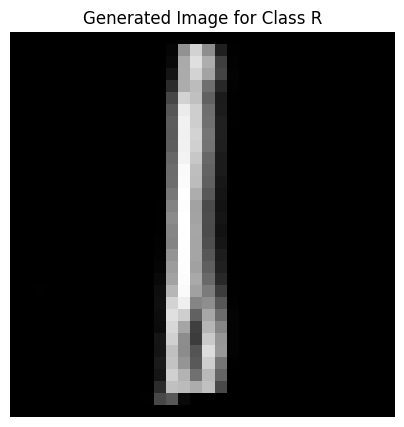

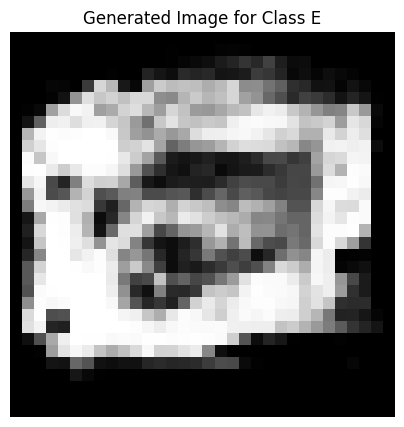

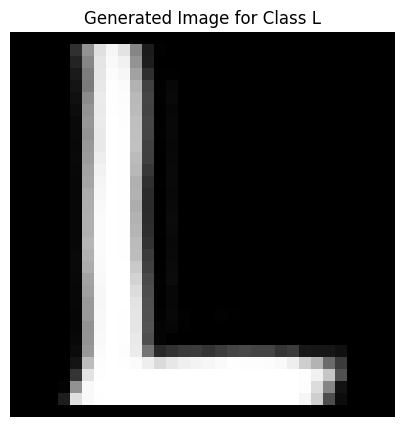

Epoch [401/500], D_loss: -0.18705996870994568, G_loss: -0.3696163296699524
Epoch [402/500], D_loss: -0.20249752700328827, G_loss: -0.3432043194770813
Epoch [403/500], D_loss: -0.1582808643579483, G_loss: -0.35723257064819336
Epoch [404/500], D_loss: -0.1898566484451294, G_loss: -0.47572317719459534
Epoch [405/500], D_loss: -0.21653391420841217, G_loss: -0.3884369134902954
Epoch [406/500], D_loss: -0.18641415238380432, G_loss: -0.4825015366077423
Epoch [407/500], D_loss: -0.2165219783782959, G_loss: -0.3098961114883423
Epoch [408/500], D_loss: -0.2215024083852768, G_loss: -0.4453839659690857
Epoch [409/500], D_loss: -0.22715657949447632, G_loss: -0.35966160893440247
Epoch [410/500], D_loss: -0.24120618402957916, G_loss: -0.3801038861274719
Epoch [411/500], D_loss: -0.20432999730110168, G_loss: -0.41189587116241455
Epoch [412/500], D_loss: -0.21746358275413513, G_loss: -0.4596298933029175
Epoch [413/500], D_loss: -0.1960543692111969, G_loss: -0.3547705411911011
Epoch [414/500], D_loss: -

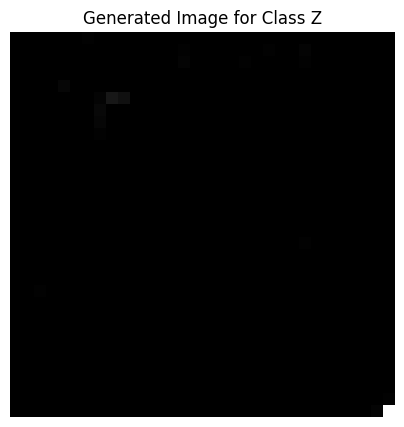

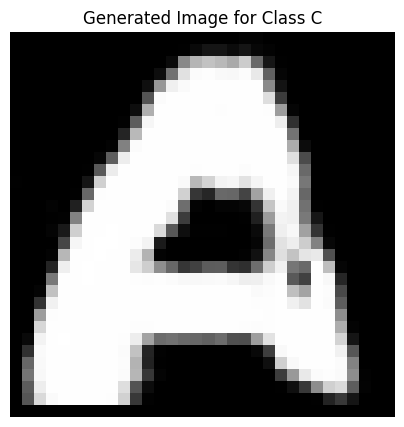

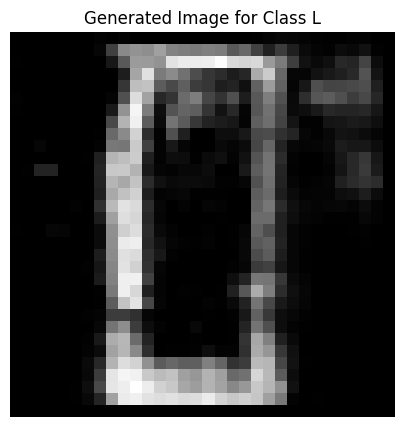

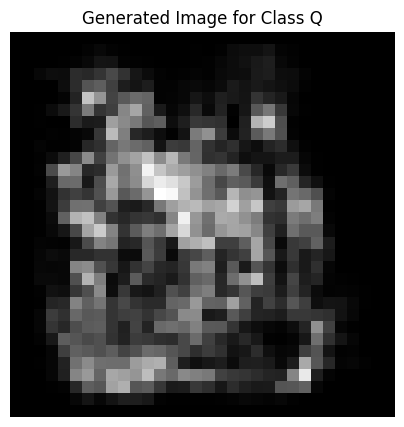

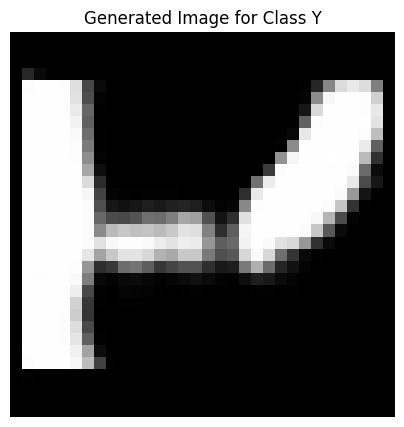

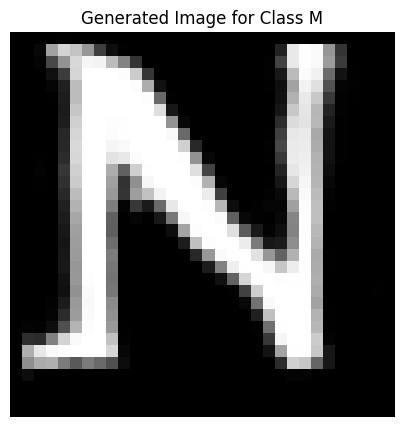

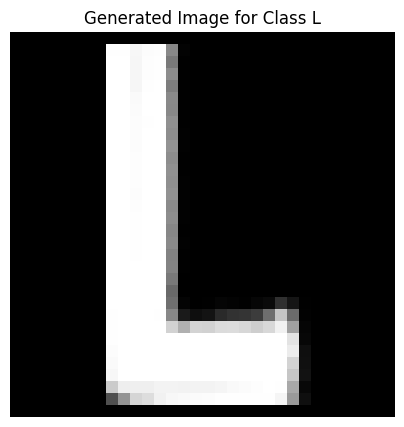

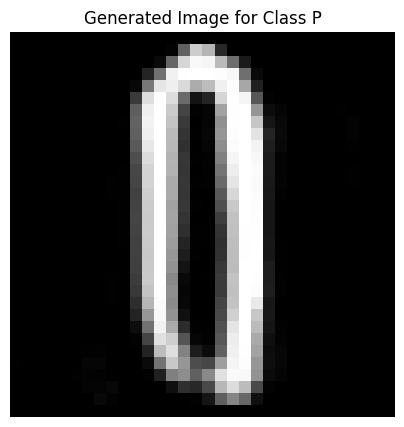

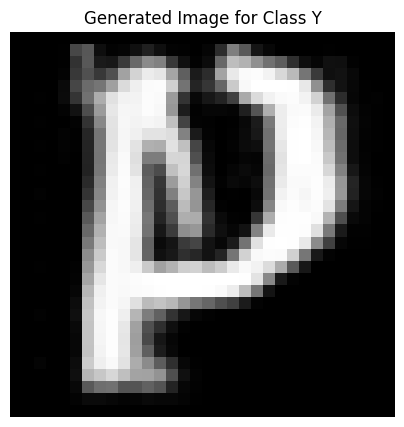

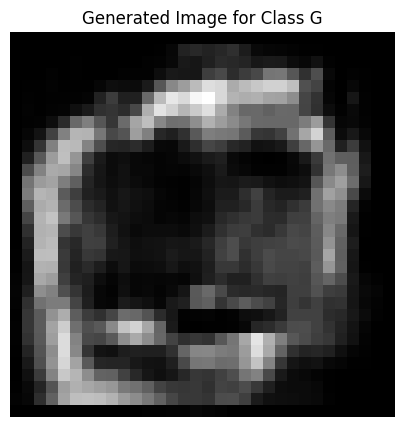

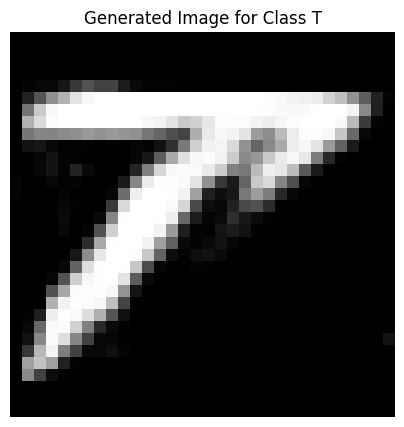

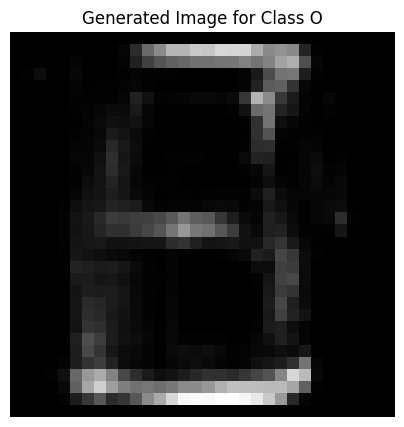

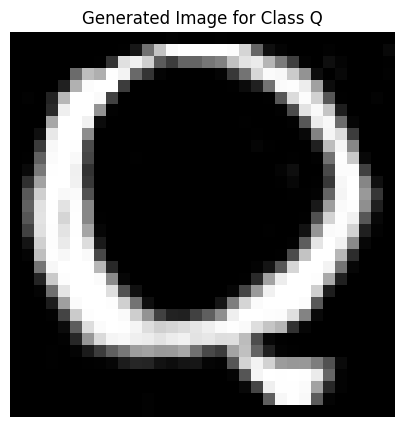

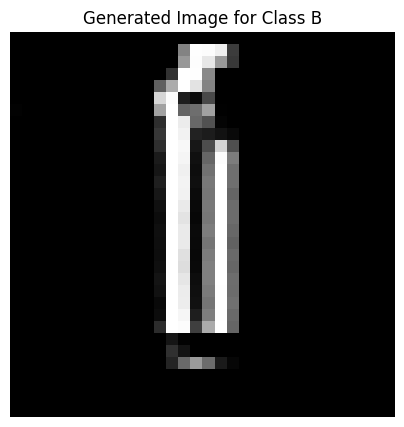

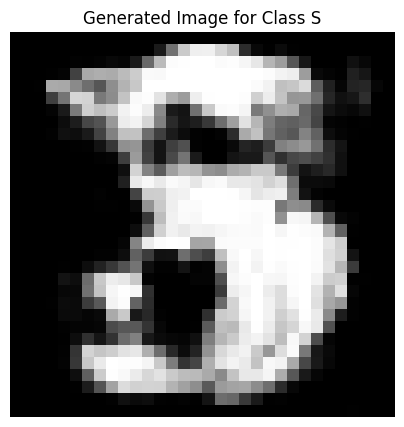

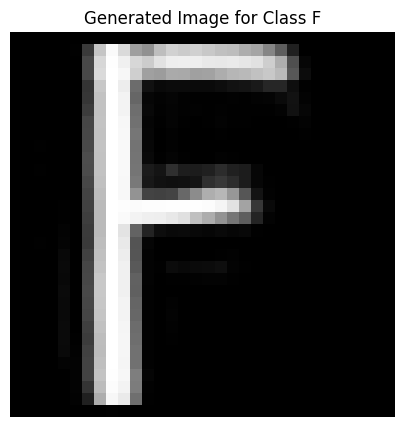

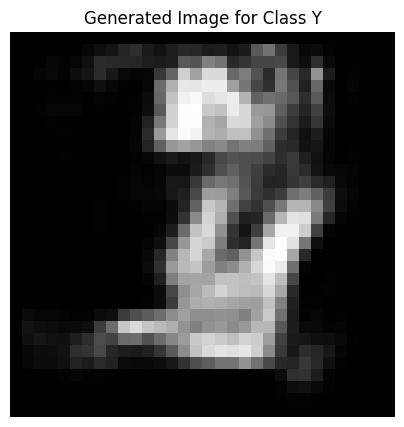

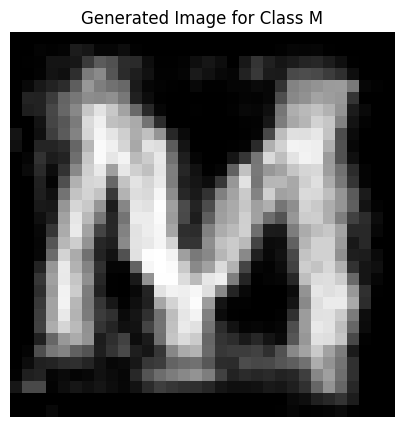

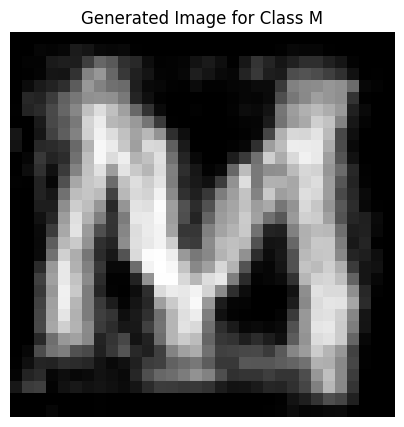

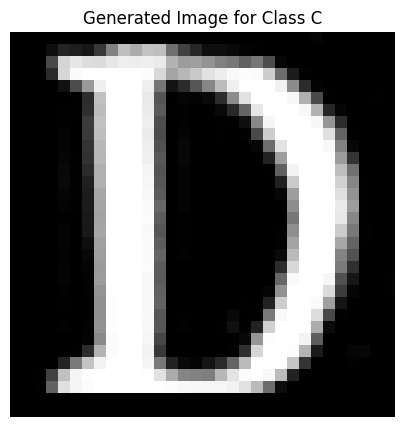

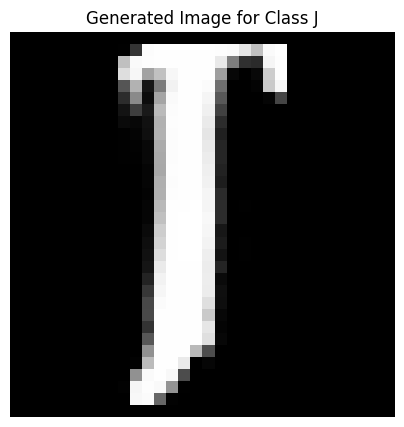

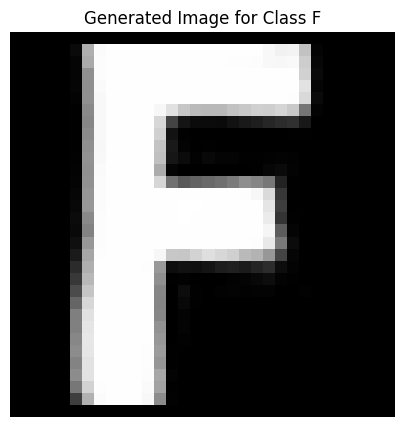

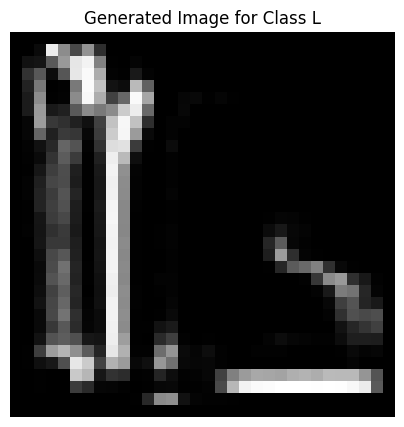

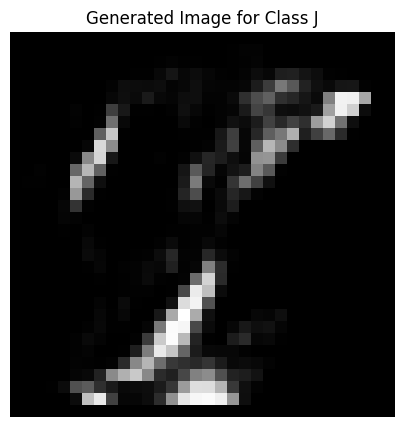

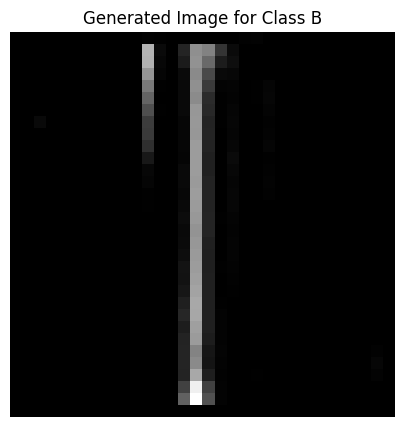

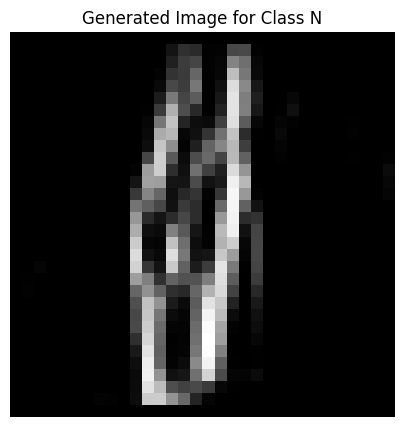

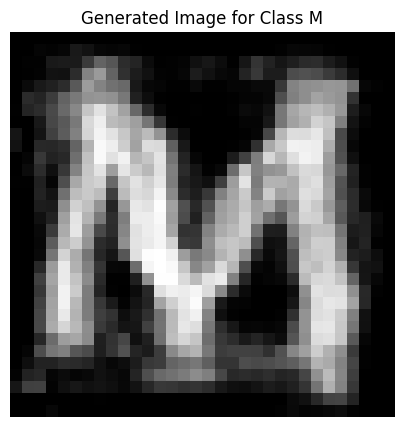

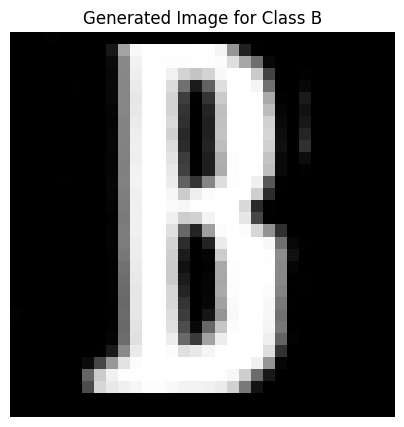

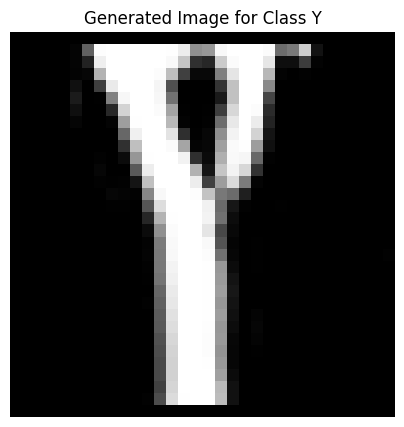

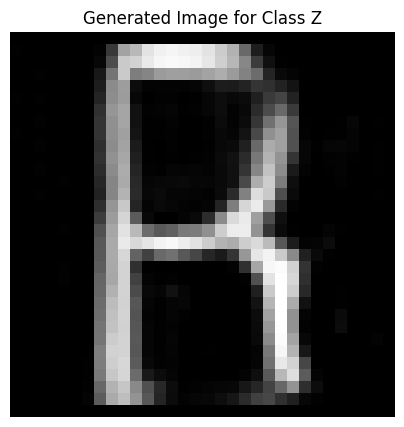

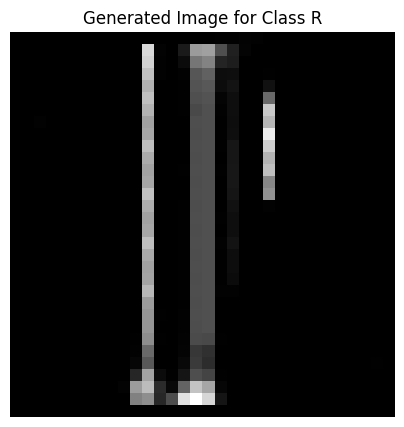

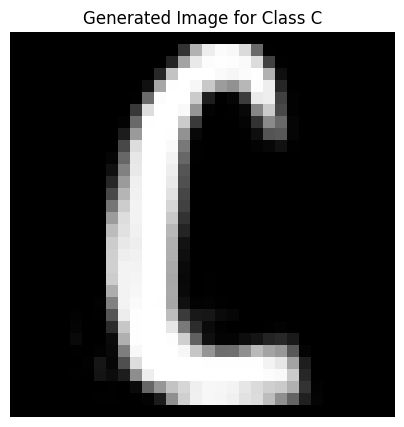

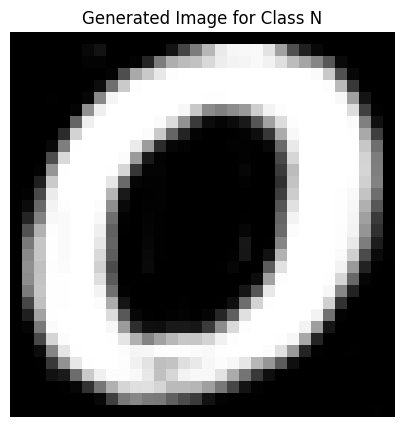

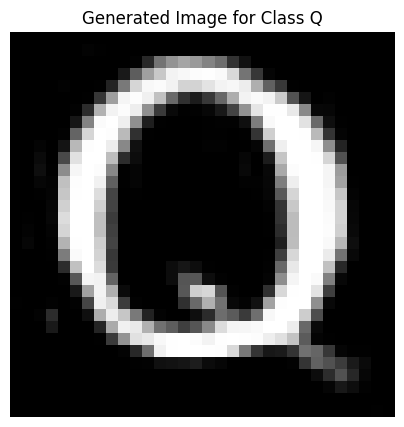

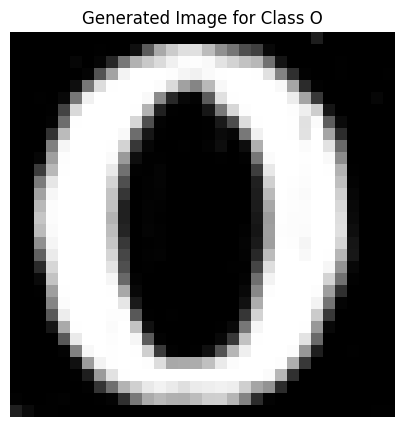

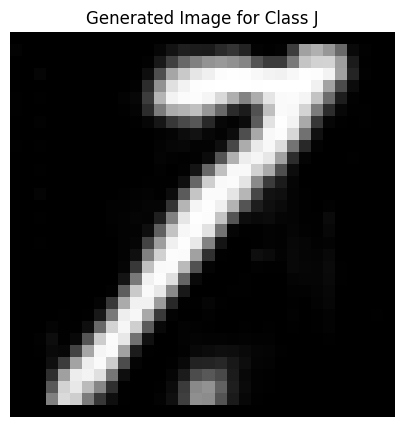

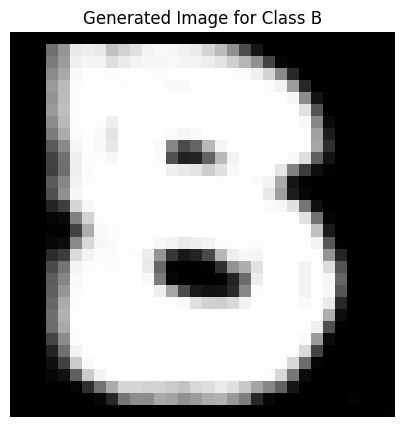

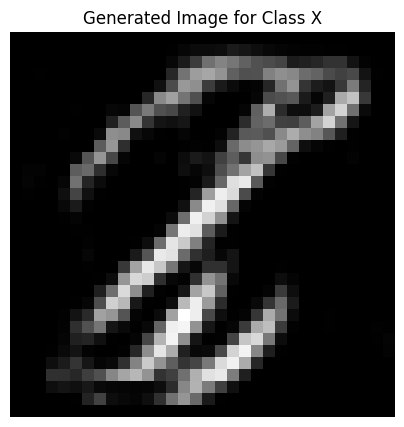

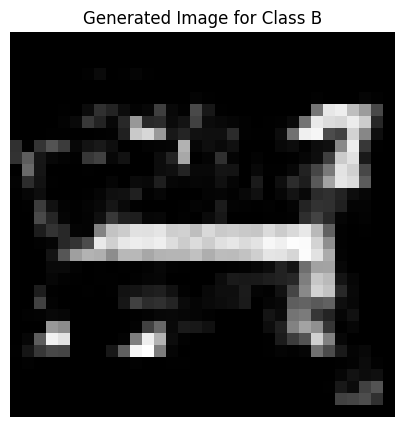

In [ ]:
for epoch in range(epochs):
    for i, (condition_imgs, target_labels, target_imgs) in enumerate(dataloader):
        # Same training process as before...
        condition_imgs = condition_imgs.unsqueeze(1).cuda()
        target_imgs = target_imgs.unsqueeze(1).cuda()
        target_labels = target_labels.cuda()
        batch_size = condition_imgs.size(0)

        # Train Discriminator
        z_s = torch.randn(batch_size, z_dim).cuda()
        condition_imgs = condition_imgs.squeeze(1)
        fake_imgs = generator(z_s, target_labels, condition_imgs)
        target_imgs = target_imgs.squeeze(1)
        real_validity = discriminator(target_imgs, target_labels, condition_imgs)
        fake_validity = discriminator(fake_imgs.detach(), target_labels, condition_imgs)

        gradient_penalty = compute_gradient_penalty(
            discriminator=discriminator,
            real_samples=target_imgs,
            fake_samples=fake_imgs,
            condition_imgs=condition_imgs,
            labels=target_labels
        )

        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

        # Train Generator every `n_critic` steps
        if i % n_critic == 0:
            z_s = torch.randn(batch_size, z_dim).cuda()
            fake_imgs = generator(z_s, target_labels, condition_imgs)
            fake_validity = discriminator(fake_imgs, target_labels, condition_imgs)
            g_loss = -torch.mean(fake_validity)

            optimizer_G.zero_grad()
            g_loss.backward()
            optimizer_G.step()

    # Print losses
    print(f"Epoch [{epoch+1}/{epochs}], D_loss: {d_loss.item()}, G_loss: {g_loss.item()}")

    # Test and visualize generator every few epochs
    if (epoch + 1) % 100 == 0:  # Test every 100 epochs
        print(f"Testing generator at epoch {epoch+1}...")
        test_generator(generator, test_dataloader, z_dim, num_classes, device)


In [1]:
z_s = torch.randn(1, z_dim).cuda()
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

for i, (condition_imgs, target_labels, target_imgs) in enumerate(test_dataloader):
    # Extract a single condition image (remove batch dimension)
    condition_img = condition_imgs.squeeze(0).cpu().numpy()[0]  # Shape: 32x32

    # Display the conditional image
    plt.figure(figsize=(5, 5))
    plt.imshow(np.uint8(np.interp(condition_img, (0, 1), (0, 255))), cmap='gray')
    plt.axis("off")
    plt.title("Conditional Input Image")
    plt.show()

    # Generate and display images for all classes
    for class_index in range(num_classes):
        displayGeneratedImage(
            class_index=class_index,
            generator=generator,
            z_s=z_s,
            num_classes=num_classes,
            condition_img=condition_imgs.squeeze(0),  # Ensure correct shape
            device=device
        )


NameError: name 'torch' is not defined